In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import pymc3 as pm
import scipy as sp
import pyccl as ccl
import os#
import utils
from make_data import MakeData
import getdist
from getdist import plots, MCSamples
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Load data

In [2]:
names_planck  = ['H0_gp', 'omega_m', 's80', 'S80']
labels_planck = [r'H_0', r'\omega_{\rm{m}}', r'\sigma_{\rm{8}}',  r'\S_{\rm{8}}']

planck1 = np.loadtxt('/home/jaimerz/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_1.txt')
planck2 = np.loadtxt('/home/jaimerz/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_2.txt')
planck3 = np.loadtxt('/home/jaimerz/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_3.txt')
planck4 = np.loadtxt('/home/jaimerz/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_4.txt')

planck_tot = np.concatenate((planck1, planck2, planck3, planck4), axis=0)

planck_params = []
for item in planck_tot:
    planck_params.append([item[29], item[32], item[34], item[35]])
planck_params = np.array(planck_params)
planck_samples = MCSamples(samples=planck_params, names = names_planck, labels = labels_planck, label= r'$Planck$ 2018',
                    weights=np.transpose(planck_tot)[0],loglikes=np.transpose(planck_tot)[1])

Removed no burn in


In [3]:
z_max = 1110
res = 200
x_arr = np.linspace(0, np.log(1+z_max), res)
dx = np.mean(np.diff(x_arr))
z_arr = np.exp(x_arr)-1
a_arr = 1./(1+z_arr)

path = '/home/jaimerz/PhD/Growz/data/products'

data_class = MakeData(z_max, res , path)
Planck = data_class.Planck
z_planck = data_class.z_planck
c = data_class.c

DESI_data = data_class.get_DESI(new=True, mode=None)
WFIRST_data = data_class.get_WFIRST(new=True)
CC_data = data_class.get_CC(new=False)
DSS_data = data_class.get_DSS(new=False)
BOSS_data = data_class.get_BOSS(new=False)
eBOSS_data = data_class.get_eBOSS(new=False)
Wigglez_data = data_class.get_Wigglez(new=False)
DS17_data = data_class.get_DS17(new=False)
CMB_data = data_class.get_CMB(new=False)

Using Planck mean
Found file for CC
Found file for DSS
Found file for BOSS
Found file for eBOSS
Found file for Wigglez
Found file for DS17
Found file for CMB


In [4]:
def get_m_s(rows):
    cols = np.transpose(rows)
    means = np.array([])
    sigmas = np.array([])
    for col in cols:
        mean = np.mean(col)
        sigma = np.std(col)
        means = np.append(means, mean)
        sigmas = np.append(sigmas, sigma)
    return means, sigmas

In [5]:
path = '/home/jaimerz/PhD/Growz/data/outputs/LCDM/'
LCDM = np.load(os.path.join(path,'LCDM_All_CMB_10000_10000/samples.npz'))

path = '/home/jaimerz/PhD/Growz/data/outputs/finals'
H = np.load(os.path.join(path, 'All_CMB_Planck_95_2500_2500/samples.npz'))

path = '/home/jaimerz/PhD/Growz/data/outputs/Xi/'
Xi = np.load(os.path.join(path,'All_CMB_best_fit_Xi_5000_5000/samples.npz'))
Xi_LCDM = np.load(os.path.join(path,'All_CMB_best_fit_Xi_LCDM_3000_5000/samples.npz'))
Xi_wCDM = np.load(os.path.join(path,'All_CMB_best_fit_Xi_wCDM_3000_5000/samples.npz'))
Xi_P18 = np.load(os.path.join(path,'All_gro_best_fit_Xi_P18_3000_5000/samples.npz'))
Xi_bfWms8 = np.load(os.path.join(path,'All_CMB_best_fit_Xi_bfWms8_7500_7500/samples.npz'))
HXi_noA0 = np.load(os.path.join(path,'All_CMB_best_fit_Xi_H_noA0_2500_2500/samples.npz'))
HXi = np.load(os.path.join(path,'All_CMB_Planck_Xi_H_1500_1500/samples.npz'))
DESI_HXi = np.load(os.path.join(path,'DESI_CMB_Planck_Xi_H_1500_1500/samples.npz'))
DESI_2X_HXi = np.load(os.path.join(path,'DESI_CMB_X2_Planck_Xi_H_1500_1500/samples.npz'))

HXi_gro = np.load(os.path.join(path,'All_gro_Planck_Xi_H_1500_1500/samples.npz'))
Xi_LCDM_gro = np.load(os.path.join(path,'All_gro_best_fit_Xi_LCDM_7500_7500/samples.npz'))
Xi_wCDM_gro = np.load(os.path.join(path,'All_gro_best_fit_Xi_wCDM_7500_7500/samples.npz'))

##Forecast 
#Desi 
#Lsst 

# Tables

In [6]:
def table_numbers(samples, sample_names):
    no_cosmo = ['Xi best-fit $\Omega_m$ and $\sigma_8$']
    table = {}
    for i, sample in enumerate(samples):
        print(sample_names[i])
        table[sample_names[i]] = {}
        
        if ('n_H' in sample.files is not None) or ('n' in sample.files is not None):
            if 'n' in sample.files:
                n_name = 'n' 
            else:
                n_name = 'n_H'
            n = sample[n_name]
            n_m = np.mean(n)
            n_s = np.std(n)
        else:
            n_m = 0
            n_s = 0
        print('n_H', n_m, '+/-', n_s)
        table[sample_names[i]]['n_H_m'] = n_m
        table[sample_names[i]]['n_H_s'] = n_s
        
        if 'n_Xi' in sample.files  is not None:
            n = sample['n_Xi']
            n_m = np.mean(n)
            n_s = np.std(n)
        else:
            n_m = 0
            n_s = 0
        print('n_Xi', n_m, '+/-', n_s)
        table[sample_names[i]]['n_Xi_m'] = n_m
        table[sample_names[i]]['n_Xi_s'] = n_s
        
        if 'H0_gp' in sample.files:
            H0 = sample['H0_gp']
            H0_m = np.mean(H0)
            H0_s = np.std(H0)
        else:
            H0_m = 0
            H0_s = 0
        print('H0', H0_m, '+/-', H0_s)
        table[sample_names[i]]['H0_m'] = H0_m
        table[sample_names[i]]['H0_s'] = H0_s
        
        if 'S80' in sample.files and sample_names[i] not in no_cosmo:
            S80 = sample['S80']
            S80_m = np.mean(S80)
            S80_s = np.std(S80)
        else:
            S80_m = 0
            S80_s = 0
        print('S80', S80_m, '+/-', S80_s)
        table[sample_names[i]]['S80_m'] = S80_m
        table[sample_names[i]]['S80_s'] = S80_s
        
        if 's80' in sample.files and sample_names[i] not in no_cosmo:
            s80 = sample['s80']
            s80_m = np.mean(s80)
            s80_s = np.std(s80)
        else:
            s80_m = 0
            s80_s = 0
        print('s80', s80_m, '+/-', s80_s)
        table[sample_names[i]]['s80_m'] = s80_m
        table[sample_names[i]]['s80_s'] = s80_s
        
        if 'Omega_m' in sample.files and sample_names[i] not in no_cosmo:
            Wm = sample['Omega_m']
            Wm_m = np.mean(Wm)
            Wm_s = np.std(Wm)
        else:
            Wm_m = 0
            Wm_s = 0
        print('Wm0', Wm_m, '+/-', Wm_s)
        table[sample_names[i]]['Wm_m'] = Wm_m
        table[sample_names[i]]['Wm_s'] = Wm_s
        print('-----')
        
        if 'Omega_m_mean' in sample.files and sample_names[i] not in no_cosmo:
            Wmm = sample['Omega_m_mean']
            Wmm_m = np.mean(Wmm)
            Wmm_s = np.std(Wmm)
        else:
            Wmm_m = 0
            Wmm_s = 0
        print('Wmm0', Wmm_m, '+/-', Wmm_s)
        table[sample_names[i]]['Wmm_m'] = Wmm_m
        table[sample_names[i]]['Wmm_s'] = Wmm_s
        print('-----')
        
        if 'w0' in sample.files and sample_names[i] not in no_cosmo:
            w0 = sample['w0']
            w0_m = np.mean(w0)
            w0_s = np.std(w0)
        else:
            w0_m = 0
            w0_s = 0
        print('w0', w0_m, '+/-', w0_s)
        table[sample_names[i]]['w0_m'] = w0_m
        table[sample_names[i]]['w0_s'] = w0_s
        print('-----')
        
        if 'wa' in sample.files and sample_names[i] not in no_cosmo:
            wa = sample['wa']
            wa_m = np.mean(wa)
            wa_s = np.std(wa)
        else:
            wa_m = 0
            wa_s = 0
        print('wa', wa_m, '+/-', wa_s)
        table[sample_names[i]]['wa_m'] = wa_m
        table[sample_names[i]]['wa_s'] = wa_s
        print('-----')
        
        if 'DHz' in sample.files and sample_names[i] != 'Best-fit $\Lambda$CDM':
            varH = np.std(sample['DHz'],0)
            varH_m = np.mean(varH)
            varH_s = np.std(varH)
        else:
            varH_m = 0
            varH_s = 0
        table[sample_names[i]]['varH_m'] = varH_m
        table[sample_names[i]]['varH_s'] = varH_s
        
        if 'DXiz' in sample.files and sample_names[i] != 'Best-fit $\Lambda$CDM':
            varXi = np.std(sample['DXiz'],0)
            varXi_m = np.mean(varXi)
            varXi_s = np.std(varXi)
        else:
            varXi_m = 0
            varXi_s = 0
        table[sample_names[i]]['varXi_m'] = varXi_m
        table[sample_names[i]]['varXi_s'] = varXi_s
        
    return table

In [7]:
numbers = table_numbers([LCDM,  H,  Xi_bfWms8, Xi, Xi_P18, Xi_LCDM, Xi_wCDM,  HXi_noA0, HXi, DESI_HXi, DESI_2X_HXi],
              ['Best-fit $\Lambda$CDM', '$H_{gp}$', '$\Xi_{gp}$ best-fit $\Omega_m$ and $\sigma_8$', 
               '$\Xi_{gp}$',  '$\Xi_{gp}^{P18}$', '$\Xi_{gp}$ $\Lambda$CDM', '$\Xi_{gp}$ $w$CDM', '$H_{gp}+\Xi_{gp}$ Hierarchical',
              '$H_{gp}+\Xi_{gp}$', 'DESI $H_{gp}+\Xi_{gp}$', 'DESI 2X $H_{gp}+\Xi_{gp}$'])

Best-fit $\Lambda$CDM
n_H 0 +/- 0
n_Xi 0 +/- 0
H0 68.33264236276125 +/- 0.5306033082125888
S80 0.7847184667858675 +/- 0.028628860586771932
s80 0.7864801966200743 +/- 0.028354541516248232
Wm0 0.29873875090920504 +/- 0.007356181408164363
-----
Wmm0 0 +/- 0
-----
w0 0 +/- 0
-----
wa 0 +/- 0
-----
$H_{gp}$
n_H 0.11083005903519336 +/- 0.09686508149872709
n_Xi 0 +/- 0
H0 67.42178837806527 +/- 0.9739784155925495
S80 0.7926653071592058 +/- 0.03008396407574879
s80 0.9578956669294237 +/- 0.16016623684627992
Wm0 0.22008883544066812 +/- 0.06506061694846052
-----
Wmm0 0 +/- 0
-----
w0 0 +/- 0
-----
wa 0 +/- 0
-----
$\Xi_{gp}$ best-fit $\Omega_m$ and $\sigma_8$
n_H 0 +/- 0
n_Xi 0.20422651799939467 +/- 0.21428718561325727
H0 68.27949251231541 +/- 0.0
S80 0 +/- 0
s80 0 +/- 0
Wm0 0 +/- 0
-----
Wmm0 0 +/- 0
-----
w0 0 +/- 0
-----
wa 0 +/- 0
-----
$\Xi_{gp}$
n_H 0 +/- 0
n_Xi 0.3584851248230947 +/- 0.26131326177393743
H0 68.27949251231541 +/- 0.0
S80 0.8583207223374464 +/- 0.17014236959424386
s80 0.960266

In [8]:
numbers_gro = table_numbers([Xi_LCDM_gro, Xi_wCDM_gro, HXi_gro],
              ['$\Xi_{gp}$ $\Lambda$CDM - Growth data', '$\Xi_{gp}$ $w$CDM - Growth data',
              '$H_{gp}+\Xi_{gp}$ - Growth data'])

$\Xi_{gp}$ $\Lambda$CDM - Growth data
n_H 0 +/- 0
n_Xi 0.3297263822861973 +/- 0.2500143876663481
H0 70.13493477181306 +/- 5.023610711108813
S80 0.8138182577916415 +/- 0.14098976814329506
s80 0.8541771875287745 +/- 0.09637023723628634
Wm0 0.2772587754323106 +/- 0.07429780063425613
-----
Wmm0 0 +/- 0
-----
w0 0 +/- 0
-----
wa 0 +/- 0
-----
$\Xi_{gp}$ $w$CDM - Growth data
n_H 0 +/- 0
n_Xi 0.3618141475524734 +/- 0.2652573168462522
H0 70.13974889141213 +/- 4.890073344625887
S80 0.9066739521154856 +/- 0.24834071980673447
s80 0.963889353218497 +/- 0.19178123751009776
Wm0 0.2828745147862283 +/- 0.12619047725566074
-----
Wmm0 0 +/- 0
-----
w0 -0.919384051483597 +/- 0.37785524324848957
-----
wa 0.03441716786672656 +/- 0.44016663602072065
-----
$H_{gp}+\Xi_{gp}$ - Growth data
n_H 0.4086071287512398 +/- 0.3169083910557596
n_Xi 0.38001679554947987 +/- 0.2346292957675957
H0 72.3837797952489 +/- 27.114390132484548
S80 0.880708320729183 +/- 0.1778725513174709
s80 0.9160992808388753 +/- 0.2299584507589

In [9]:
def make_table(numbers):
    names = numbers.keys()
    for name in names:
        Wm = '${} \pm {}$'.format(round(numbers[name]['Wm_m'],3), round(numbers[name]['Wm_s'],3))
        s80 = '${} \pm {}$'.format(round(numbers[name]['s80_m'],3), round(numbers[name]['s80_s'],3))
        S80 = '${} \pm {}$'.format(round(numbers[name]['S80_m'],3), round(numbers[name]['S80_s'],3))
        H0 = '${} \pm {}$'.format(round(numbers[name]['H0_m'],3), round(numbers[name]['H0_s'],3))
        print(name, '&', Wm, '&',  s80, '&',  S80, '&',  H0, r'\\' )

In [10]:
def make_table2(numbers):
    names = numbers.keys()
    for name in names:
        n_H = '${} \pm {}$'.format(round(numbers[name]['n_H_m'],3), round(numbers[name]['n_H_s'],3))
        n_Xi = '${} \pm {}$'.format(round(numbers[name]['n_Xi_m'],3), round(numbers[name]['n_Xi_s'],3))
        varH = '${} \pm {}$'.format(round(numbers[name]['varH_m'],3), round(numbers[name]['varH_s'],3))
        varXi = '${} \pm {}$'.format(round(numbers[name]['varXi_m'],3), round(numbers[name]['varXi_s'],3))
        print(name, '&', n_H, '&', varH, '&', n_Xi, '&', varXi, r'\\' )

In [11]:
make_table(numbers)

Best-fit $\Lambda$CDM & $0.299 \pm 0.007$ & $0.786 \pm 0.028$ & $0.785 \pm 0.029$ & $68.333 \pm 0.531$ \\
$H_{gp}$ & $0.22 \pm 0.065$ & $0.958 \pm 0.16$ & $0.793 \pm 0.03$ & $67.422 \pm 0.974$ \\
$\Xi_{gp}$ best-fit $\Omega_m$ and $\sigma_8$ & $0 \pm 0$ & $0 \pm 0$ & $0 \pm 0$ & $68.279 \pm 0.0$ \\
$\Xi_{gp}$ & $0.269 \pm 0.139$ & $0.96 \pm 0.185$ & $0.858 \pm 0.17$ & $68.279 \pm 0.0$ \\
$\Xi_{gp}^{P18}$ & $0.316 \pm 0.008$ & $0.852 \pm 0.114$ & $0.874 \pm 0.117$ & $67.269 \pm 0.59$ \\
$\Xi_{gp}$ $\Lambda$CDM & $0.298 \pm 0.007$ & $0.859 \pm 0.121$ & $0.856 \pm 0.121$ & $67.682 \pm 0.764$ \\
$\Xi_{gp}$ $w$CDM & $0.294 \pm 0.01$ & $0.858 \pm 0.128$ & $0.849 \pm 0.128$ & $68.057 \pm 1.051$ \\
$H_{gp}+\Xi_{gp}$ Hierarchical & $0.281 \pm 0.165$ & $0.96 \pm 0.184$ & $0.874 \pm 0.212$ & $68.002 \pm 0.731$ \\
$H_{gp}+\Xi_{gp}$ & $0.277 \pm 0.163$ & $0.959 \pm 0.186$ & $0.868 \pm 0.214$ & $67.427 \pm 0.954$ \\
DESI $H_{gp}+\Xi_{gp}$ & $0.356 \pm 0.133$ & $0.826 \pm 0.039$ & $0.884 \pm 0.149$ &

In [12]:
make_table(numbers_gro)

$\Xi_{gp}$ $\Lambda$CDM - Growth data & $0.277 \pm 0.074$ & $0.854 \pm 0.096$ & $0.814 \pm 0.141$ & $70.135 \pm 5.024$ \\
$\Xi_{gp}$ $w$CDM - Growth data & $0.283 \pm 0.126$ & $0.964 \pm 0.192$ & $0.907 \pm 0.248$ & $70.14 \pm 4.89$ \\
$H_{gp}+\Xi_{gp}$ - Growth data & $0.329 \pm 0.174$ & $0.916 \pm 0.23$ & $0.881 \pm 0.178$ & $72.384 \pm 27.114$ \\


In [13]:
make_table2(numbers)

Best-fit $\Lambda$CDM & $0 \pm 0$ & $0 \pm 0$ & $0 \pm 0$ & $0 \pm 0$ \\
$H_{gp}$ & $0.111 \pm 0.097$ & $0.084 \pm 0.01$ & $0 \pm 0$ & $0 \pm 0$ \\
$\Xi_{gp}$ best-fit $\Omega_m$ and $\sigma_8$ & $0 \pm 0$ & $0 \pm 0$ & $0.204 \pm 0.214$ & $0.207 \pm 0.057$ \\
$\Xi_{gp}$ & $0 \pm 0$ & $0 \pm 0$ & $0.358 \pm 0.261$ & $0.38 \pm 0.023$ \\
$\Xi_{gp}^{P18}$ & $0 \pm 0$ & $0 \pm 0$ & $0.318 \pm 0.236$ & $0.3 \pm 0.06$ \\
$\Xi_{gp}$ $\Lambda$CDM & $0 \pm 0$ & $0 \pm 0$ & $0.312 \pm 0.24$ & $0.303 \pm 0.053$ \\
$\Xi_{gp}$ $w$CDM & $0 \pm 0$ & $0 \pm 0$ & $0.327 \pm 0.257$ & $0.359 \pm 0.067$ \\
$H_{gp}+\Xi_{gp}$ Hierarchical & $0.021 \pm 0.018$ & $0.016 \pm 0.003$ & $0.359 \pm 0.264$ & $0.379 \pm 0.025$ \\
$H_{gp}+\Xi_{gp}$ & $0.106 \pm 0.099$ & $0.082 \pm 0.009$ & $0.349 \pm 0.262$ & $0.385 \pm 0.011$ \\
DESI $H_{gp}+\Xi_{gp}$ & $0.071 \pm 0.066$ & $0.062 \pm 0.003$ & $0.315 \pm 0.247$ & $0.332 \pm 0.02$ \\
DESI 2X $H_{gp}+\Xi_{gp}$ & $0.074 \pm 0.083$ & $0.065 \pm 0.003$ & $0.187 \pm 0.17$ &

In [14]:
make_table2(numbers_gro)

$\Xi_{gp}$ $\Lambda$CDM - Growth data & $0 \pm 0$ & $0 \pm 0$ & $0.33 \pm 0.25$ & $0.341 \pm 0.038$ \\
$\Xi_{gp}$ $w$CDM - Growth data & $0 \pm 0$ & $0 \pm 0$ & $0.362 \pm 0.265$ & $0.389 \pm 0.036$ \\
$H_{gp}+\Xi_{gp}$ - Growth data & $0.409 \pm 0.317$ & $0.503 \pm 0.066$ & $0.38 \pm 0.235$ & $0.358 \pm 0.015$ \\


# $\sigma_\Xi$ - $\sigma_H$ Plots

In [15]:
def make_var_fz(fz):
    var = np.std(fz, 0)
    var_m = np.mean(var)
    var_s = np.std(var)
    return var_m, var_s

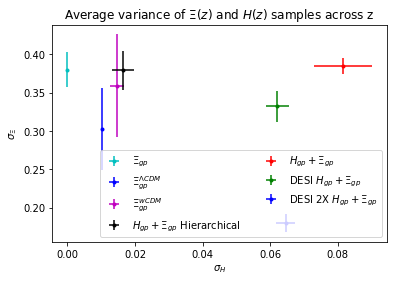

In [16]:
runs = {'$\Xi_{gp}$': Xi, 
        '$\Xi_{gp}^{\Lambda CDM}$': Xi_LCDM, 
        '$\Xi_{gp}^{wCDM}$': Xi_wCDM,
        '$H_{gp}+\Xi_{gp}$ Hierarchical': HXi_noA0,
        '$H_{gp}+\Xi_{gp}$': HXi,
        'DESI $H_{gp}+\Xi_{gp}$': DESI_HXi,
        'DESI 2X $H_{gp}+\Xi_{gp}$': DESI_2X_HXi}
fmts = {'$\Xi_{gp}$': 'c.',
        '$\Xi_{gp}^{\Lambda CDM}$': 'b.', 
        '$\Xi_{gp}^{wCDM}$': 'm.',
        '$H_{gp}+\Xi_{gp}$ Hierarchical': 'k.',
        '$H_{gp}+\Xi_{gp}$': 'r.', 
        'DESI $H_{gp}+\Xi_{gp}$': 'g.',
        'DESI 2X $H_{gp}+\Xi_{gp}$': 'b.' }

for name in runs.keys():
    run = runs[name]
    if 'DHz' in run.files:
        var_H, var_H_err=make_var_fz(run['DHz'])
    else:
        var_H, var_H_err=make_var_fz(run['Hz']/data_class.H_arr-1)
    var_Xi, var_Xi_err=make_var_fz(run['DXiz'])
    plt.errorbar(var_H, var_Xi, xerr=np.transpose(var_H_err), yerr=np.transpose(var_Xi_err),
                 fmt=fmts[name], label=name)
#plt.xlim([-0.01 , 0.1])
#plt.ylim([0.33 , 0.43])
plt.legend(loc='lower right', ncol=2)
plt.xlabel('$\sigma_H$')
plt.ylabel('$\sigma_\Xi$')
plt.title('Average variance of $\Xi(z)$ and $H(z)$ samples across z');

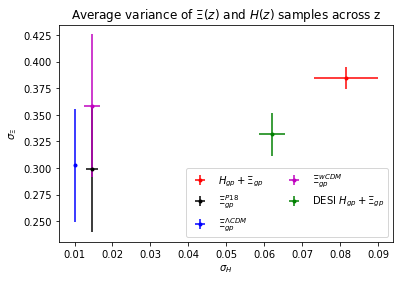

In [48]:
runs = {'$H_{gp}+\Xi_{gp}$': HXi,
        '$\Xi_{gp}^{P18}$': Xi_P18,
        '$\Xi_{gp}^{\Lambda CDM}$': Xi_LCDM, 
        '$\Xi_{gp}^{wCDM}$': Xi_wCDM,
        'DESI $H_{gp}+\Xi_{gp}$': DESI_HXi}
fmts = {'$H_{gp}+\Xi_{gp}$': 'r.', 
        '$\Xi_{gp}^{P18}$': 'k.',
        '$\Xi_{gp}^{\Lambda CDM}$': 'b.', 
        '$\Xi_{gp}^{wCDM}$': 'm.',
        'DESI $H_{gp}+\Xi_{gp}$': 'g.',}

for name in runs.keys():
    run = runs[name]
    if 'DHz' in run.files:
        var_H, var_H_err=make_var_fz(run['DHz'])
    else:
        var_H, var_H_err=make_var_fz(run['Hz']/data_class.H_arr-1)
    var_Xi, var_Xi_err=make_var_fz(run['DXiz'])
    plt.errorbar(var_H, var_Xi, xerr=np.transpose(var_H_err), yerr=np.transpose(var_Xi_err),
                 fmt=fmts[name], label=name)
#plt.xlim([-0.01 , 0.1])
#plt.ylim([0.33 , 0.43])
plt.legend(loc='lower right', ncol=2)
plt.xlabel('$\sigma_H$')
plt.ylabel('$\sigma_\Xi$')
plt.title('Average variance of $\Xi(z)$ and $H(z)$ samples across z');

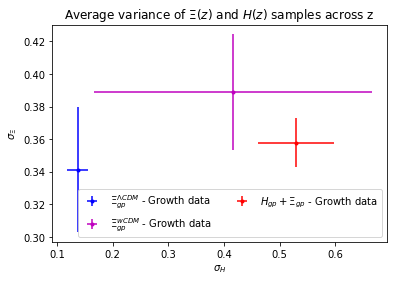

In [18]:
runs = {'$\Xi_{gp}^{\Lambda CDM}$ - Growth data': Xi_LCDM_gro, 
        '$\Xi_{gp}^{wCDM}$ - Growth data': Xi_wCDM_gro,
        '$H_{gp}+\Xi_{gp}$ - Growth data': HXi_gro}
fmts = {'$\Xi_{gp}^{\Lambda CDM}$ - Growth data': 'b.', 
        '$\Xi_{gp}^{wCDM}$ - Growth data': 'm.',
        '$H_{gp}+\Xi_{gp}$ - Growth data': 'r.'}

for name in runs.keys():
    run = runs[name]
    var_H, var_H_err=make_var_fz(1-run['Hz']/Xi['Hz'][1])
    var_Xi, var_Xi_err=make_var_fz(run['DXiz'])
    plt.errorbar(var_H, var_Xi, xerr=np.transpose(var_H_err), yerr=np.transpose(var_Xi_err),
                 fmt=fmts[name], label=name)
#plt.xlim([-0.01 , 0.1])
#plt.ylim([0.33 , 0.43])
plt.legend(loc='lower right', ncol=2)
plt.xlabel('$\sigma_H$')
plt.ylabel('$\sigma_\Xi$')
plt.title('Average variance of $\Xi(z)$ and $H(z)$ samples across z');

# 1D Comp

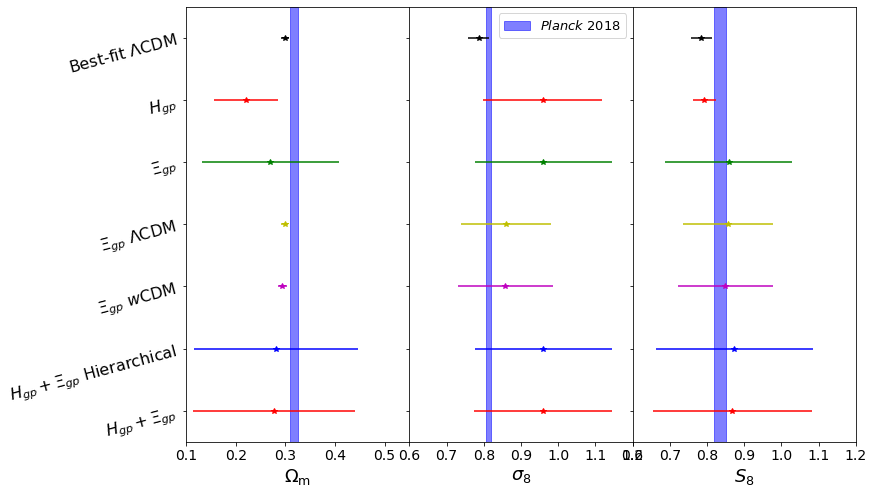

In [19]:
fig=plt.figure(figsize=(12,8))
fig.subplots_adjust(wspace=0)

my_yticks = ['Best-fit $\Lambda$CDM', '$H_{gp}$', 
               '$\Xi_{gp}$', '$\Xi_{gp}$ $\Lambda$CDM', '$\Xi_{gp}$ $w$CDM',
             '$H_{gp}+\Xi_{gp}$ Hierarchical', '$H_{gp}+\Xi_{gp}$']

fmts = {'Best-fit $\Lambda$CDM': 'k*', 
        '$H_{gp}$': 'r*', 
        '$\Xi_{gp}$': 'g*',
        '$\Xi_{gp}$ $\Lambda$CDM': 'y*', 
        '$\Xi_{gp}$ $w$CDM': 'm*',
        '$H_{gp}+\Xi_{gp}$ Hierarchical': 'b*',
        '$H_{gp}+\Xi_{gp}$': 'r*'}

y = {'Best-fit $\Lambda$CDM': 0, 
    '$H_{gp}$': 2, 
    '$\Xi_{gp}$': 4,
    '$\Xi_{gp}$ $\Lambda$CDM': 6, 
    '$\Xi_{gp}$ $w$CDM': 8,
    '$H_{gp}+\Xi_{gp}$ Hierarchical': 10,
    '$H_{gp}+\Xi_{gp}$': 12}

ax1 = plt.subplot(131)
label = r'$\Omega_{\rm{m}}$'
plt.axvspan(0.3166 - 0.0084, 0.3166 + 0.0084, alpha = 0.5, color='b',  label= r'$Planck$ 2018')
for name in my_yticks:
    Wm=numbers[name]['Wm_m']
    Wm_err=numbers[name]['Wm_s']
    plt.errorbar( Wm, y[name], xerr=np.transpose(Wm_err), fmt=fmts[name])

plt.yticks(list(y.values()), list(y.keys()), fontsize=16)
plt.xlabel(label, fontsize=18)
plt.axis([0.1, 0.55, y[my_yticks[-1]]+1 ,-1,])
plt.yticks(rotation=15)
plt.xticks(fontsize=14)

    
ax2 = plt.subplot(132, sharey = ax1)
label = r'$\sigma_{\rm{8}}$'
plt.axvspan(0.8120 - 0.0073, 0.8120 + 0.0073, alpha = 0.5, color='b',  label= r'$Planck$ 2018')
for name in my_yticks:
    s8=numbers[name]['s80_m']
    s8_err=numbers[name]['s80_s']
    plt.errorbar( s8, y[name], xerr=np.transpose(s8_err), fmt=fmts[name])
plt.xlabel(label, fontsize=18)
plt.legend(loc = 1, prop={'size': 13})
plt.axis([0.6, 1.2, y[my_yticks[-1]]+1 ,-1,])
plt.setp( ax2.get_yticklabels(), visible=False)
plt.xticks(fontsize=14)
    
ax3 = plt.subplot(133, sharey = ax2)
label = r'$S_{\rm{8}}$'
plt.axvspan(0.834 - 0.016, 0.834 + 0.016, alpha = 0.5, color='b',  label= r'$Planck$ 2018')
for name in my_yticks:
    S8=numbers[name]['S80_m']
    S8_err=numbers[name]['S80_s']
    plt.errorbar( S8, y[name], xerr=np.transpose(S8_err), fmt=fmts[name])
plt.xlabel(label, fontsize=18)
#plt.legend(loc = 1, prop={'size': 13})
plt.axis([0.6, 1.2, y[my_yticks[-1]]+1 ,-1,])
plt.setp( ax3.get_yticklabels(), visible=False)
plt.xticks(fontsize=14)

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/1D_comp.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/1D_comp.pdf')

# Triangle Plots

In [20]:
labels_dict = {'n': '\eta_H',
               'l': 'l_H',
               'A0': 'A0',
               'n_H': '\eta_H',
               'l_H': 'l_H',
               'n_Xi': '\eta_{\Xi}',
               'l_Xi': 'l_{\Xi}',
               'mu_0': '\mu(0)',
               'H0': 'H_0',
               'H0_gp': 'H_0',
               'w0': 'w_0',
               'wa': 'w_a',
               'Omega_m': '\Omega_m',
               'Omega_m_mean': '\Omega_m^{mean}',
               's80': '\sigma_8',
               'S80': 'S_8',
               'rd': 'r_s',
               'M': 'M'}
names_All = ['n', 'l', 'n_H', 'l_H', 'n_Xi', 'l_Xi',#
             'H0', 'H0_gp',  'Omega_m', 'Omega_m', 
             'Omega_m_mean', 'w0', 'wa', 's80', 'S80', 'M']
#ranges = {'l':[0.001, 7], 'omega_b': [0.022, 0.023]}
ranges = {'l':[0.001, 7], 'l_Xi':[0.001, 7], 'l_H':[0.001, 7], 'n':[0., 2], 'n_H':[0., 2], 'n_Xi':[0., 2]}

In [21]:
np.transpose(HXi['Xiz'])[0].shape

(6000,)

In [22]:
def make_samples(file, names, ranges, label):
    namess = []
    labels = []
    samples = []
    for name in names:
        if name in file.keys():
            namess.append(name) 
            labels.append(labels_dict[name]) 
            samples.append(file[name])
    if 'Xiz' in file.keys():
        namess.append('mu_0')
        labels.append(labels_dict['mu_0'])
        samples.append(np.transpose(file['Xiz'])[0])
    return MCSamples(samples=samples, names=namess, labels=labels, label=label, ranges=ranges,
                    settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.3})

In [23]:
LCDM_samples = make_samples(LCDM, ['H0_gp', 'Omega_m', 's80', 'S80', 'rd', 'M'], ranges, r'$\Lambda$CDM')
H_samples = make_samples(H, ['A0', 'n_H', 'l_H', 'H0_gp', 'Omega_m', 's80', 'S80', 'rd', 'M'], ranges, 'Fiducial')
Xi_samples = make_samples(Xi, ['n_Xi', 'l_Xi',  'mu_0', 'H0_gp', 'Omega_m', 's80', 'S80', 'rd', 'M'],
                          ranges, r'$\Xi_{gp}$')
Xi_LCDM_samples = make_samples(Xi_LCDM, ['n_Xi', 'l_Xi', 'mu_0', 'H0_gp', 'Omega_m', 'Omega_m_mean', 's80', 'S80', 'rd', 'M'],
                          ranges, r'$\Xi_{gp}^{\Lambda CDM}$')
Xi_wCDM_samples = make_samples(Xi_wCDM, ['n_Xi', 'l_Xi', 'mu_0', 'H0_gp', 'Omega_m', 'Omega_m_mean', 'w0', 'wa', 's80', 'S80', 'rd', 'M'],
                          ranges, r'$\Xi_{gp}^{wCDM}$')
Xi_LCDM_gro_samples = make_samples(Xi_LCDM_gro, ['n_Xi', 'l_Xi', 'H0_gp', 'Omega_m', 'Omega_m_mean', 's80', 'S80'],
                          ranges, r'$\Xi_{gp}^{\Lambda CDM}$ - Growth data')
Xi_wCDM_gro_samples = make_samples(Xi_wCDM_gro, ['n_Xi', 'l_Xi', 'H0_gp', 'Omega_m', 'Omega_m_mean', 'w0', 'wa', 's80', 'S80'],
                          ranges, r'$\Xi_{gp}^{wCDM}$ - Growth data')
Xi_bfWms8_samples = make_samples(Xi_bfWms8, ['n_Xi', 'l_Xi', 'H0_gp', 'rd', 'M'],
                                 ranges, r'$\Xi_{gp}$ - Best Fit $\Omega_m$ $\sigma_8$')
HXi_noA0_samples = make_samples(HXi_noA0, ['n_H', 'l_H', 'n_Xi', 'l_Xi', 'H0_gp', 'Omega_m', 's80', 'S80', 'rd', 'M'],
                                ranges, '$H_{gp}+\Xi_{gp}$ Hierarchical')
HXi_samples = make_samples(HXi, ['n_H', 'l_H', 'n_Xi', 'l_Xi', 'A0', 'H0_gp', 'Omega_m', 's80', 'S80', 'rd', 'M'],
                                ranges, '$H_{gp}+\Xi_{gp}$')
HXi_gro_samples = make_samples(HXi_gro, ['n_H', 'l_H', 'n_Xi', 'l_Xi', 'A0', 'H0_gp', 'Omega_m', 's80', 'S80'],
                                ranges, '$H_{gp}+\Xi_{gp}$ - Growth data')
DESI_HXi_samples = make_samples(DESI_HXi, ['n_H', 'l_H', 'n_Xi', 'l_Xi', 'A0', 'H0_gp', 'Omega_m', 's80', 'S80', 'rd'],
                                ranges, 'DESI $H_{gp}+\Xi_{gp}$')
DESI_2X_HXi_samples = make_samples(DESI_2X_HXi, ['n_H', 'l_H', 'n_Xi', 'l_Xi', 'A0', 'H0_gp', 'Omega_m', 's80', 'S80', 'rd'],
                                ranges, 'DESI 2X $H_{gp}+\Xi_{gp}$')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


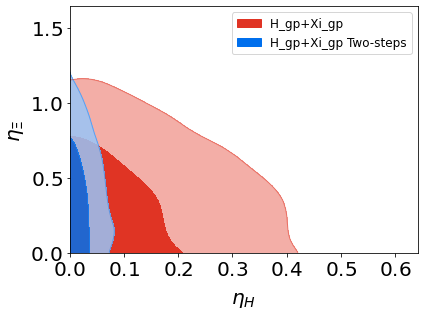

In [24]:
g = plots.get_single_plotter()
g.settings.axes_fontsize=20
g.settings.axes_labelsize = 20
g.plot_2d([HXi_samples, HXi_noA0_samples],
          'n_H', 'n_Xi', filled=True)
g.add_legend(['H_gp+Xi_gp ', 'H_gp+Xi_gp Two-steps'])

g.export('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/eta_eta.pdf')

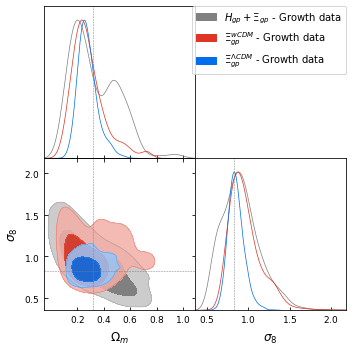

In [25]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([HXi_gro_samples, Xi_wCDM_gro_samples, Xi_LCDM_gro_samples],
                ['Omega_m', 's80'],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         'Omega_m_mean': data_class.cosmo.Omega_m(),
                         'w0': -1,
                         'wa': 0,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                        'rd':147.06546072,
                         'M': -19.2})
              
g.export('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/triangle_Xi_data.pdf')

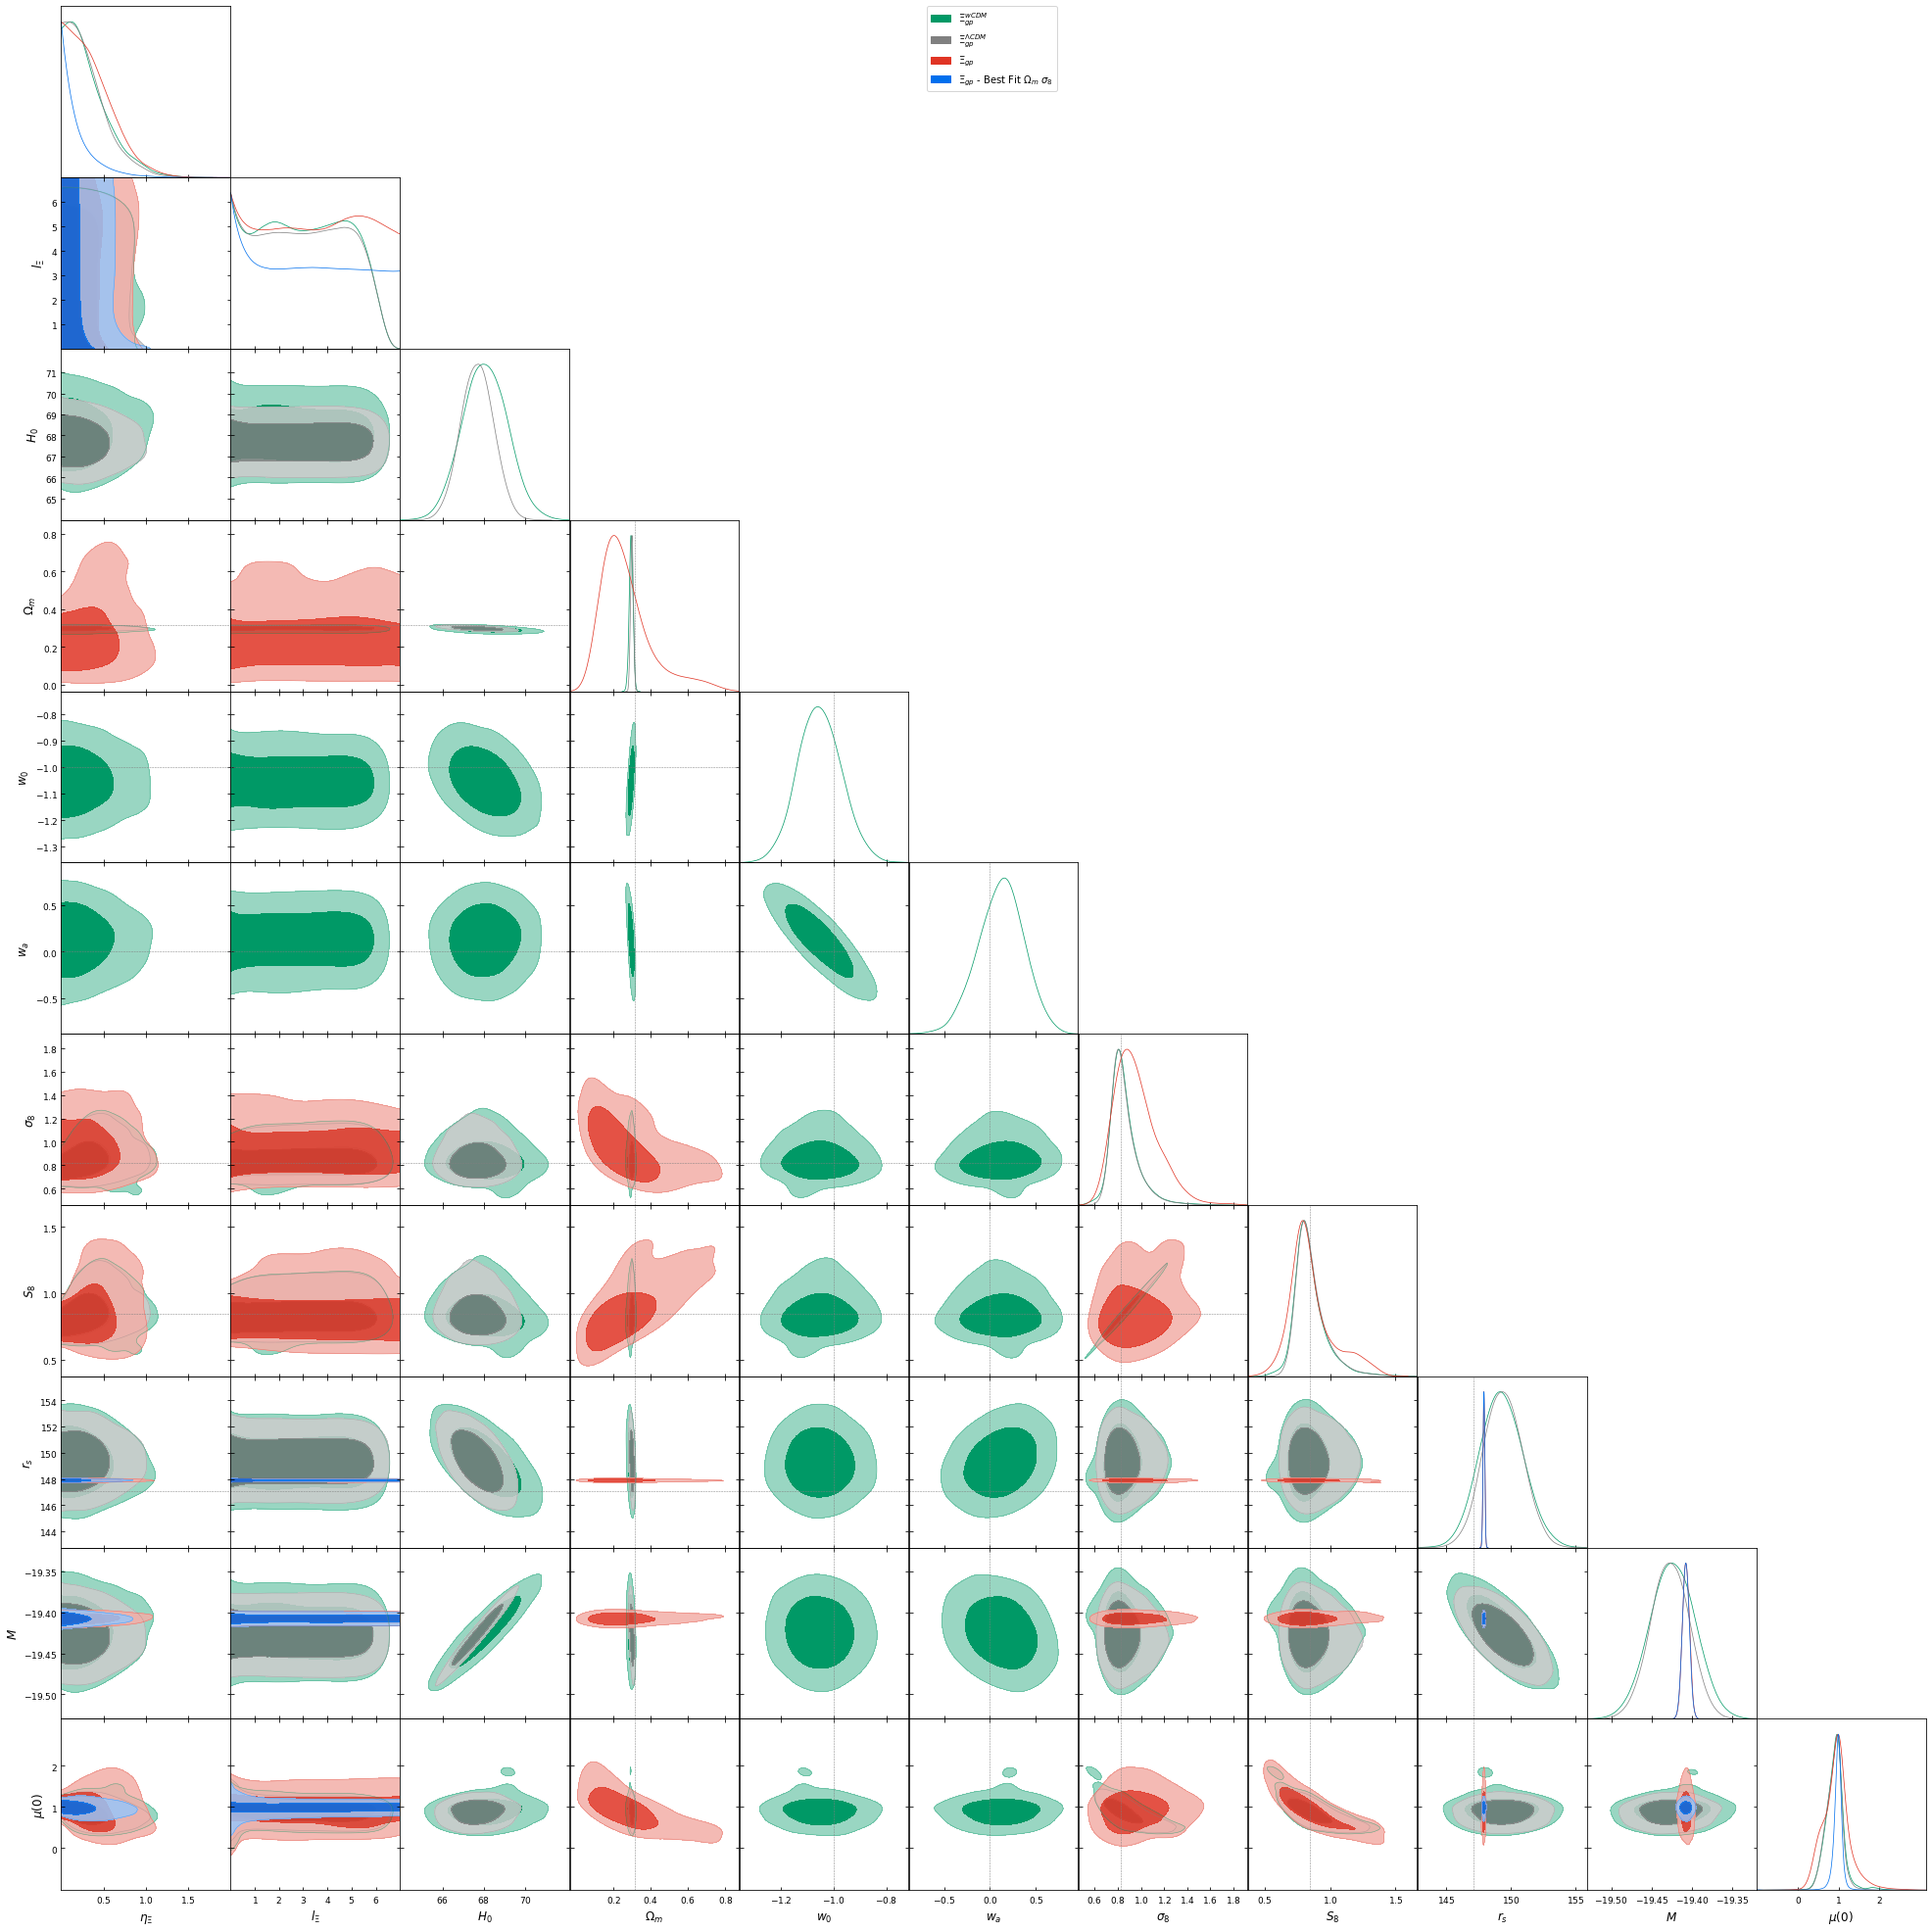

In [26]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([Xi_wCDM_samples, Xi_LCDM_samples, Xi_samples, Xi_bfWms8_samples],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         'Omega_m_mean': data_class.cosmo.Omega_m(),
                         'w0': -1,
                         'wa': 0,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                        'rd':147.06546072,
                         'M': -19.2})
              
g.export('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/triangle_Xi_data.pdf')

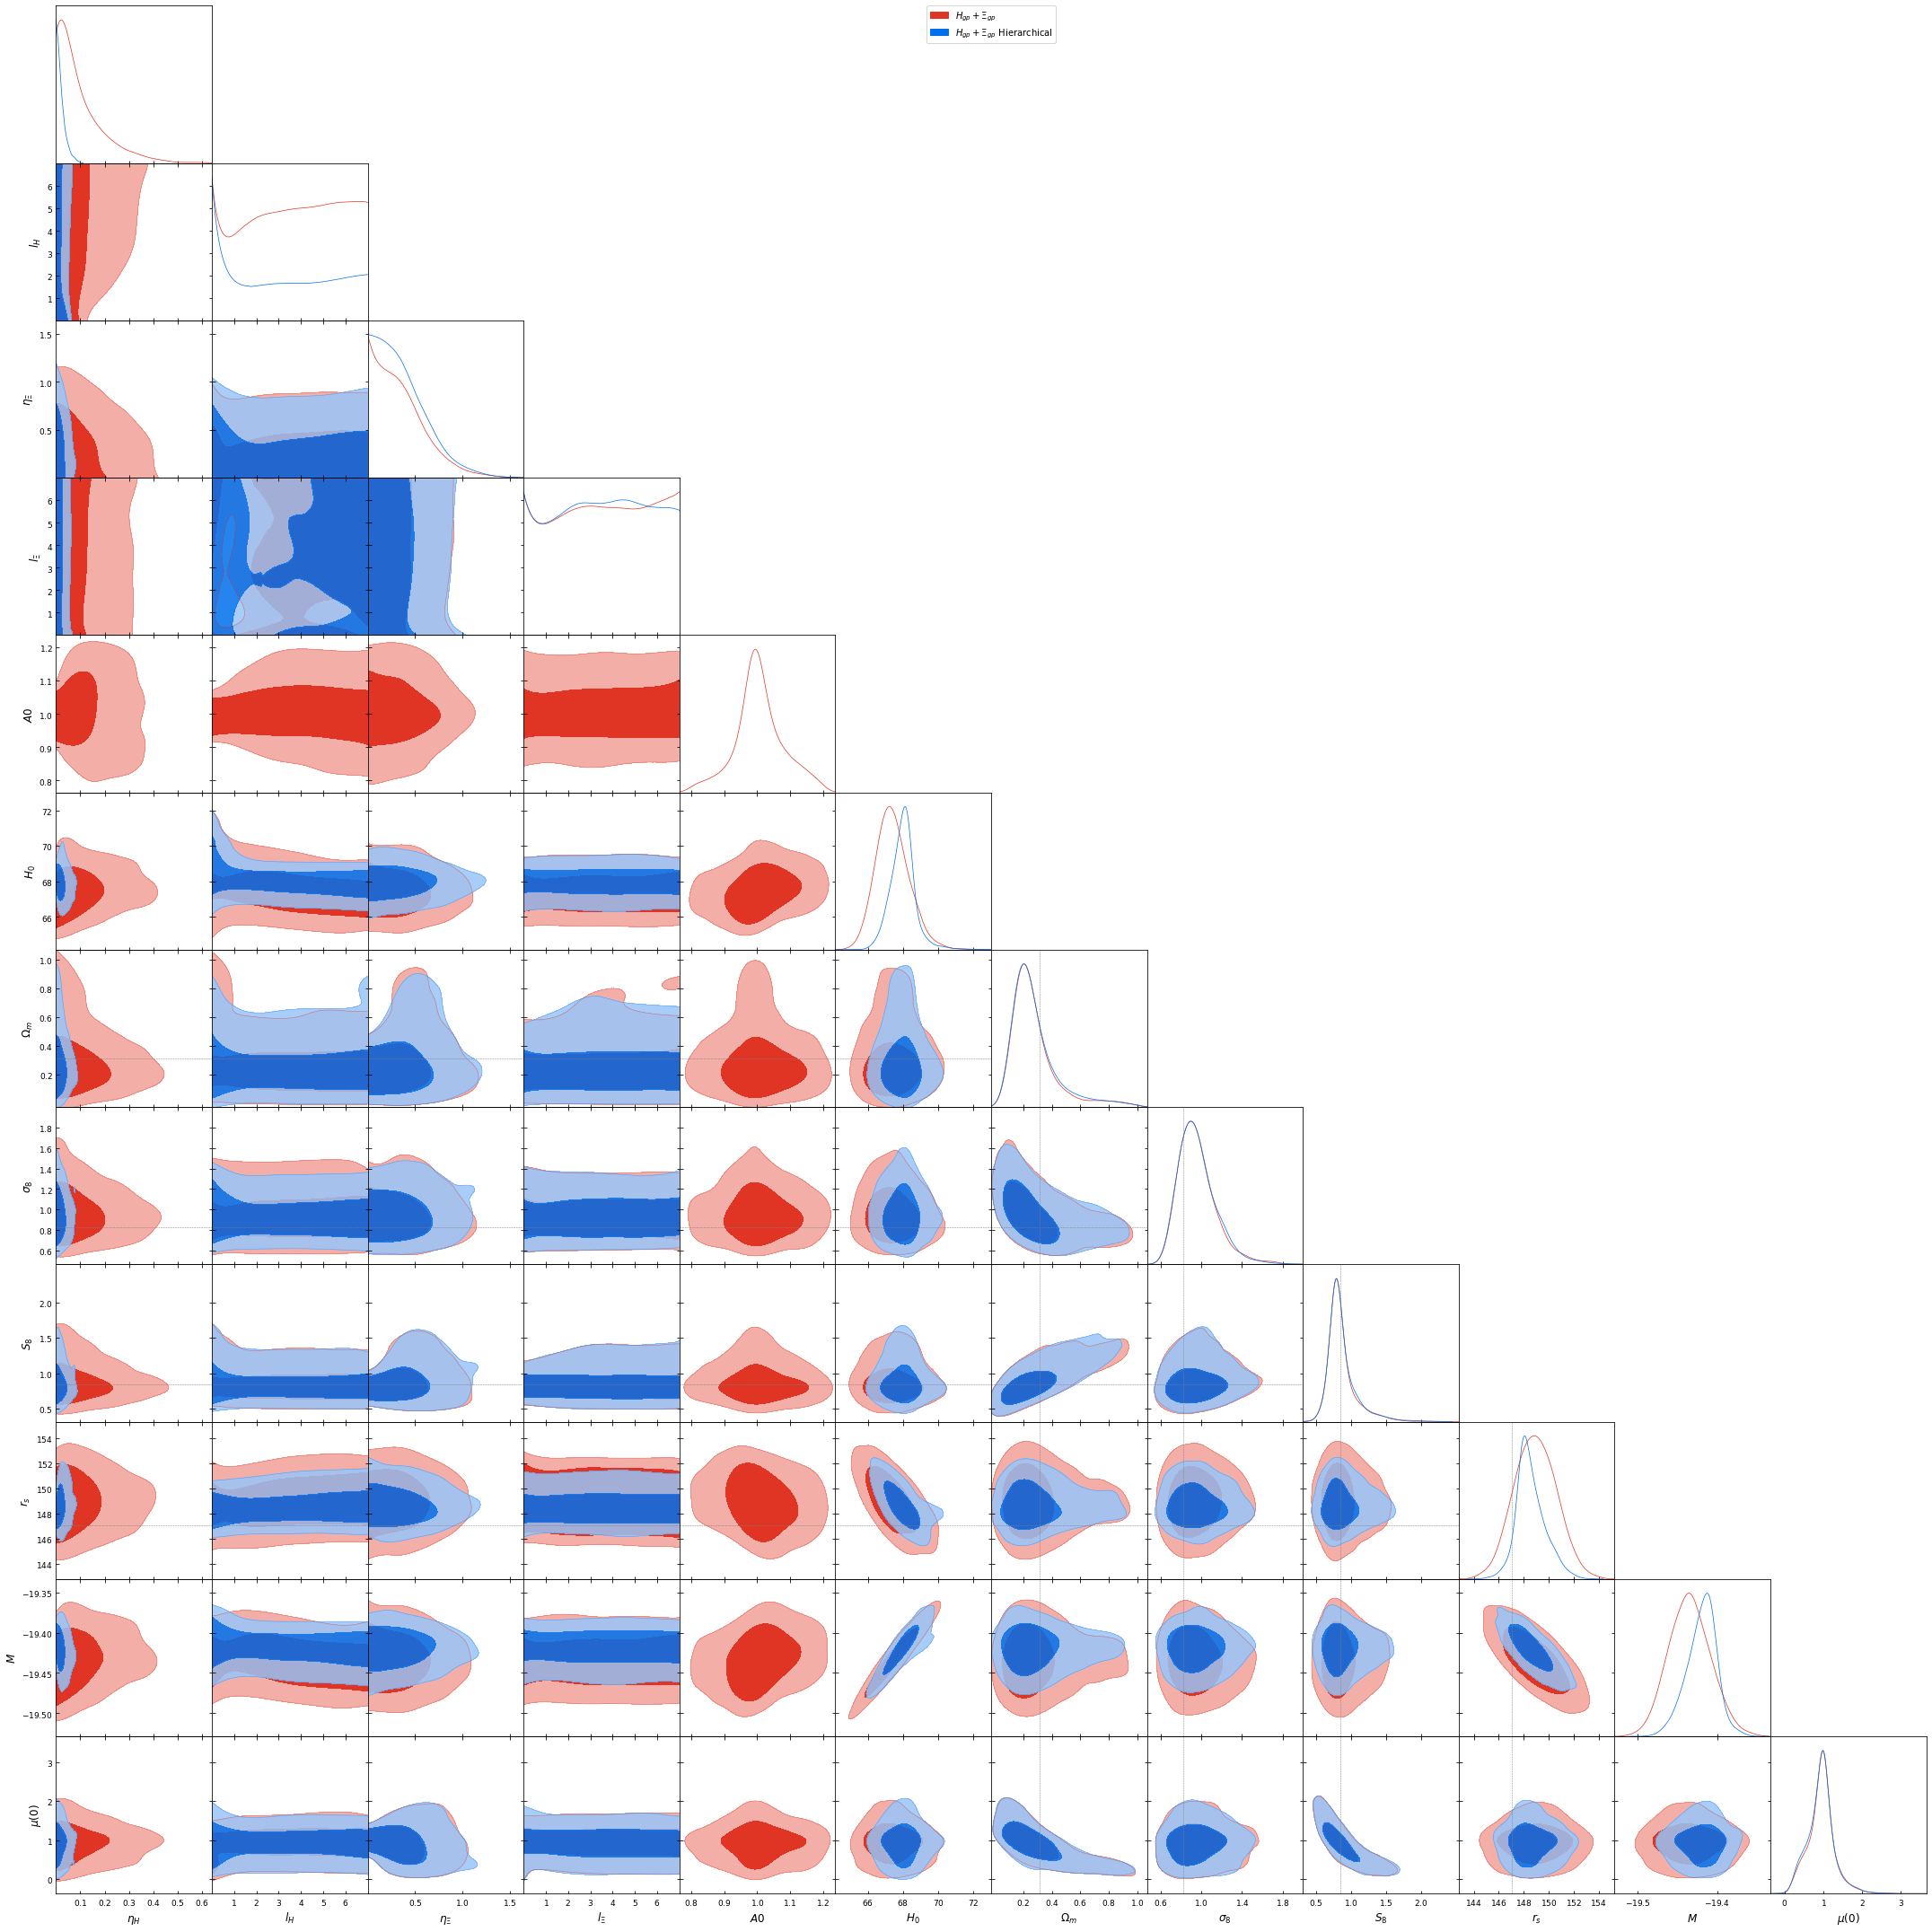

In [27]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([ HXi_samples, HXi_noA0_samples],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                         'rd':147.06546072,
                         'M': -19.2})
              
g.export('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/triangle_Xi_H.pdf')

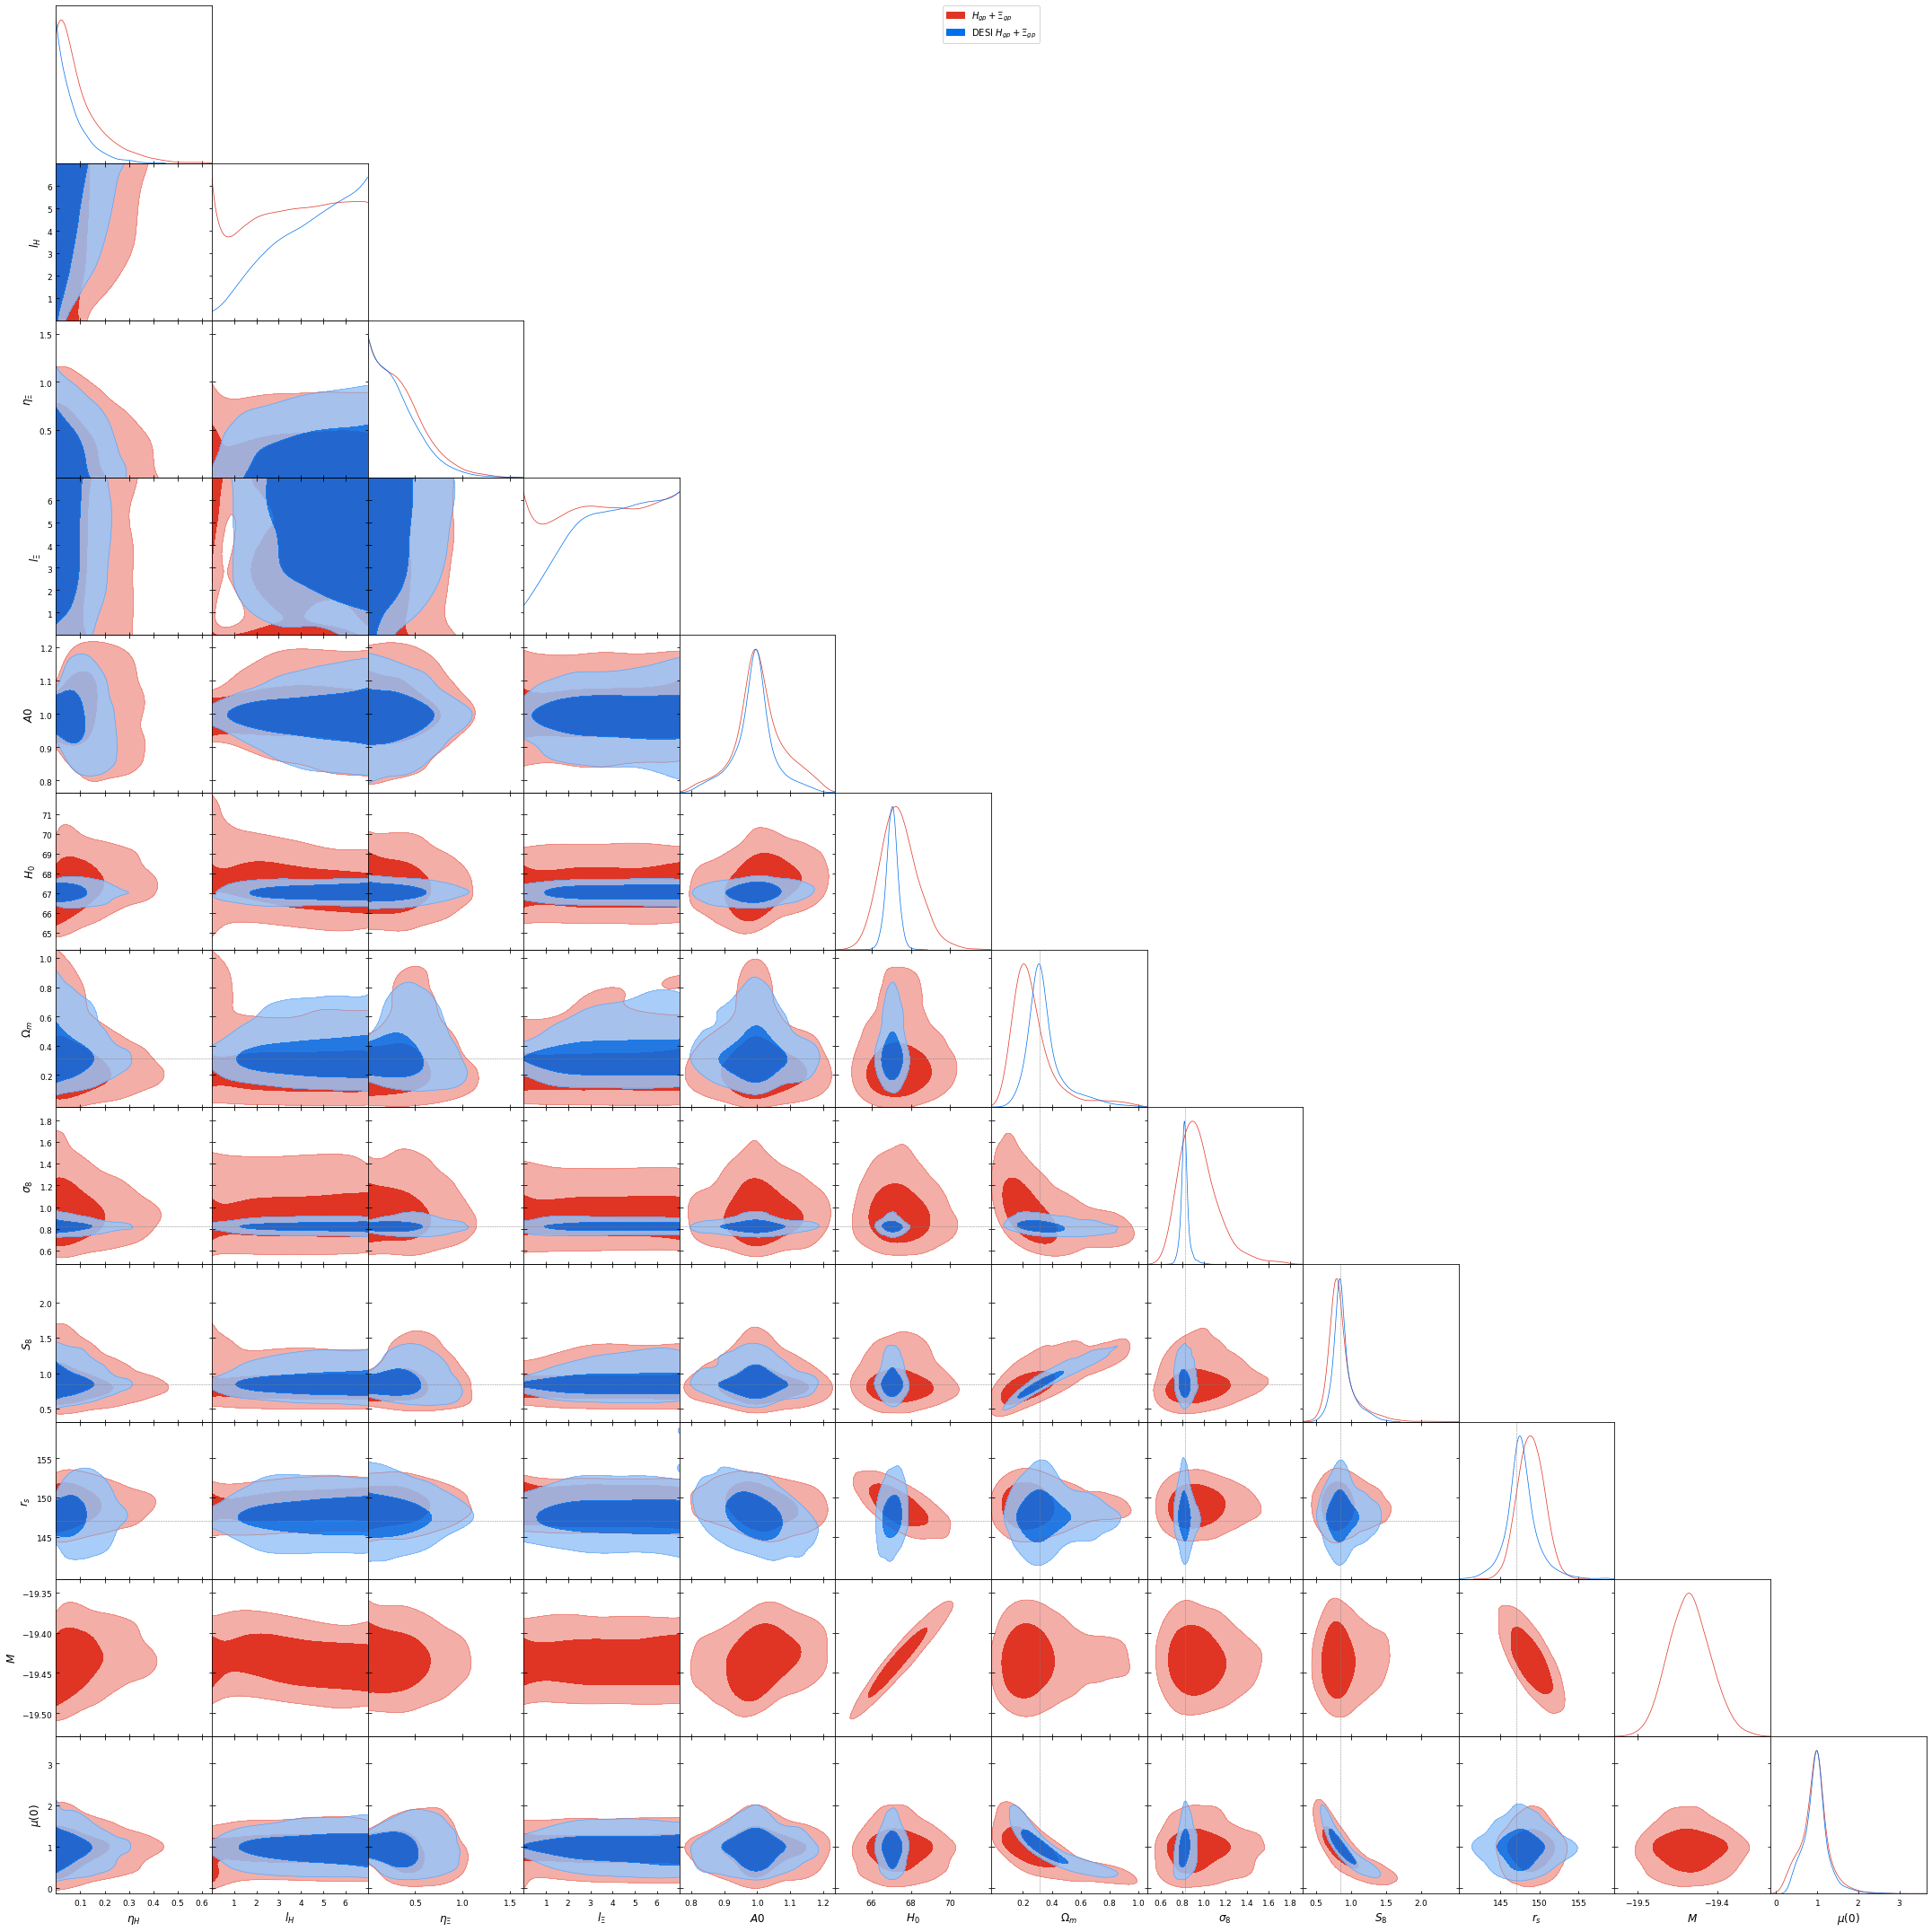

In [28]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([ HXi_samples, DESI_HXi_samples],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                         'rd':147.06546072,
                         'M': -19.2})
              
g.export('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/triangle_Xi_H.pdf')

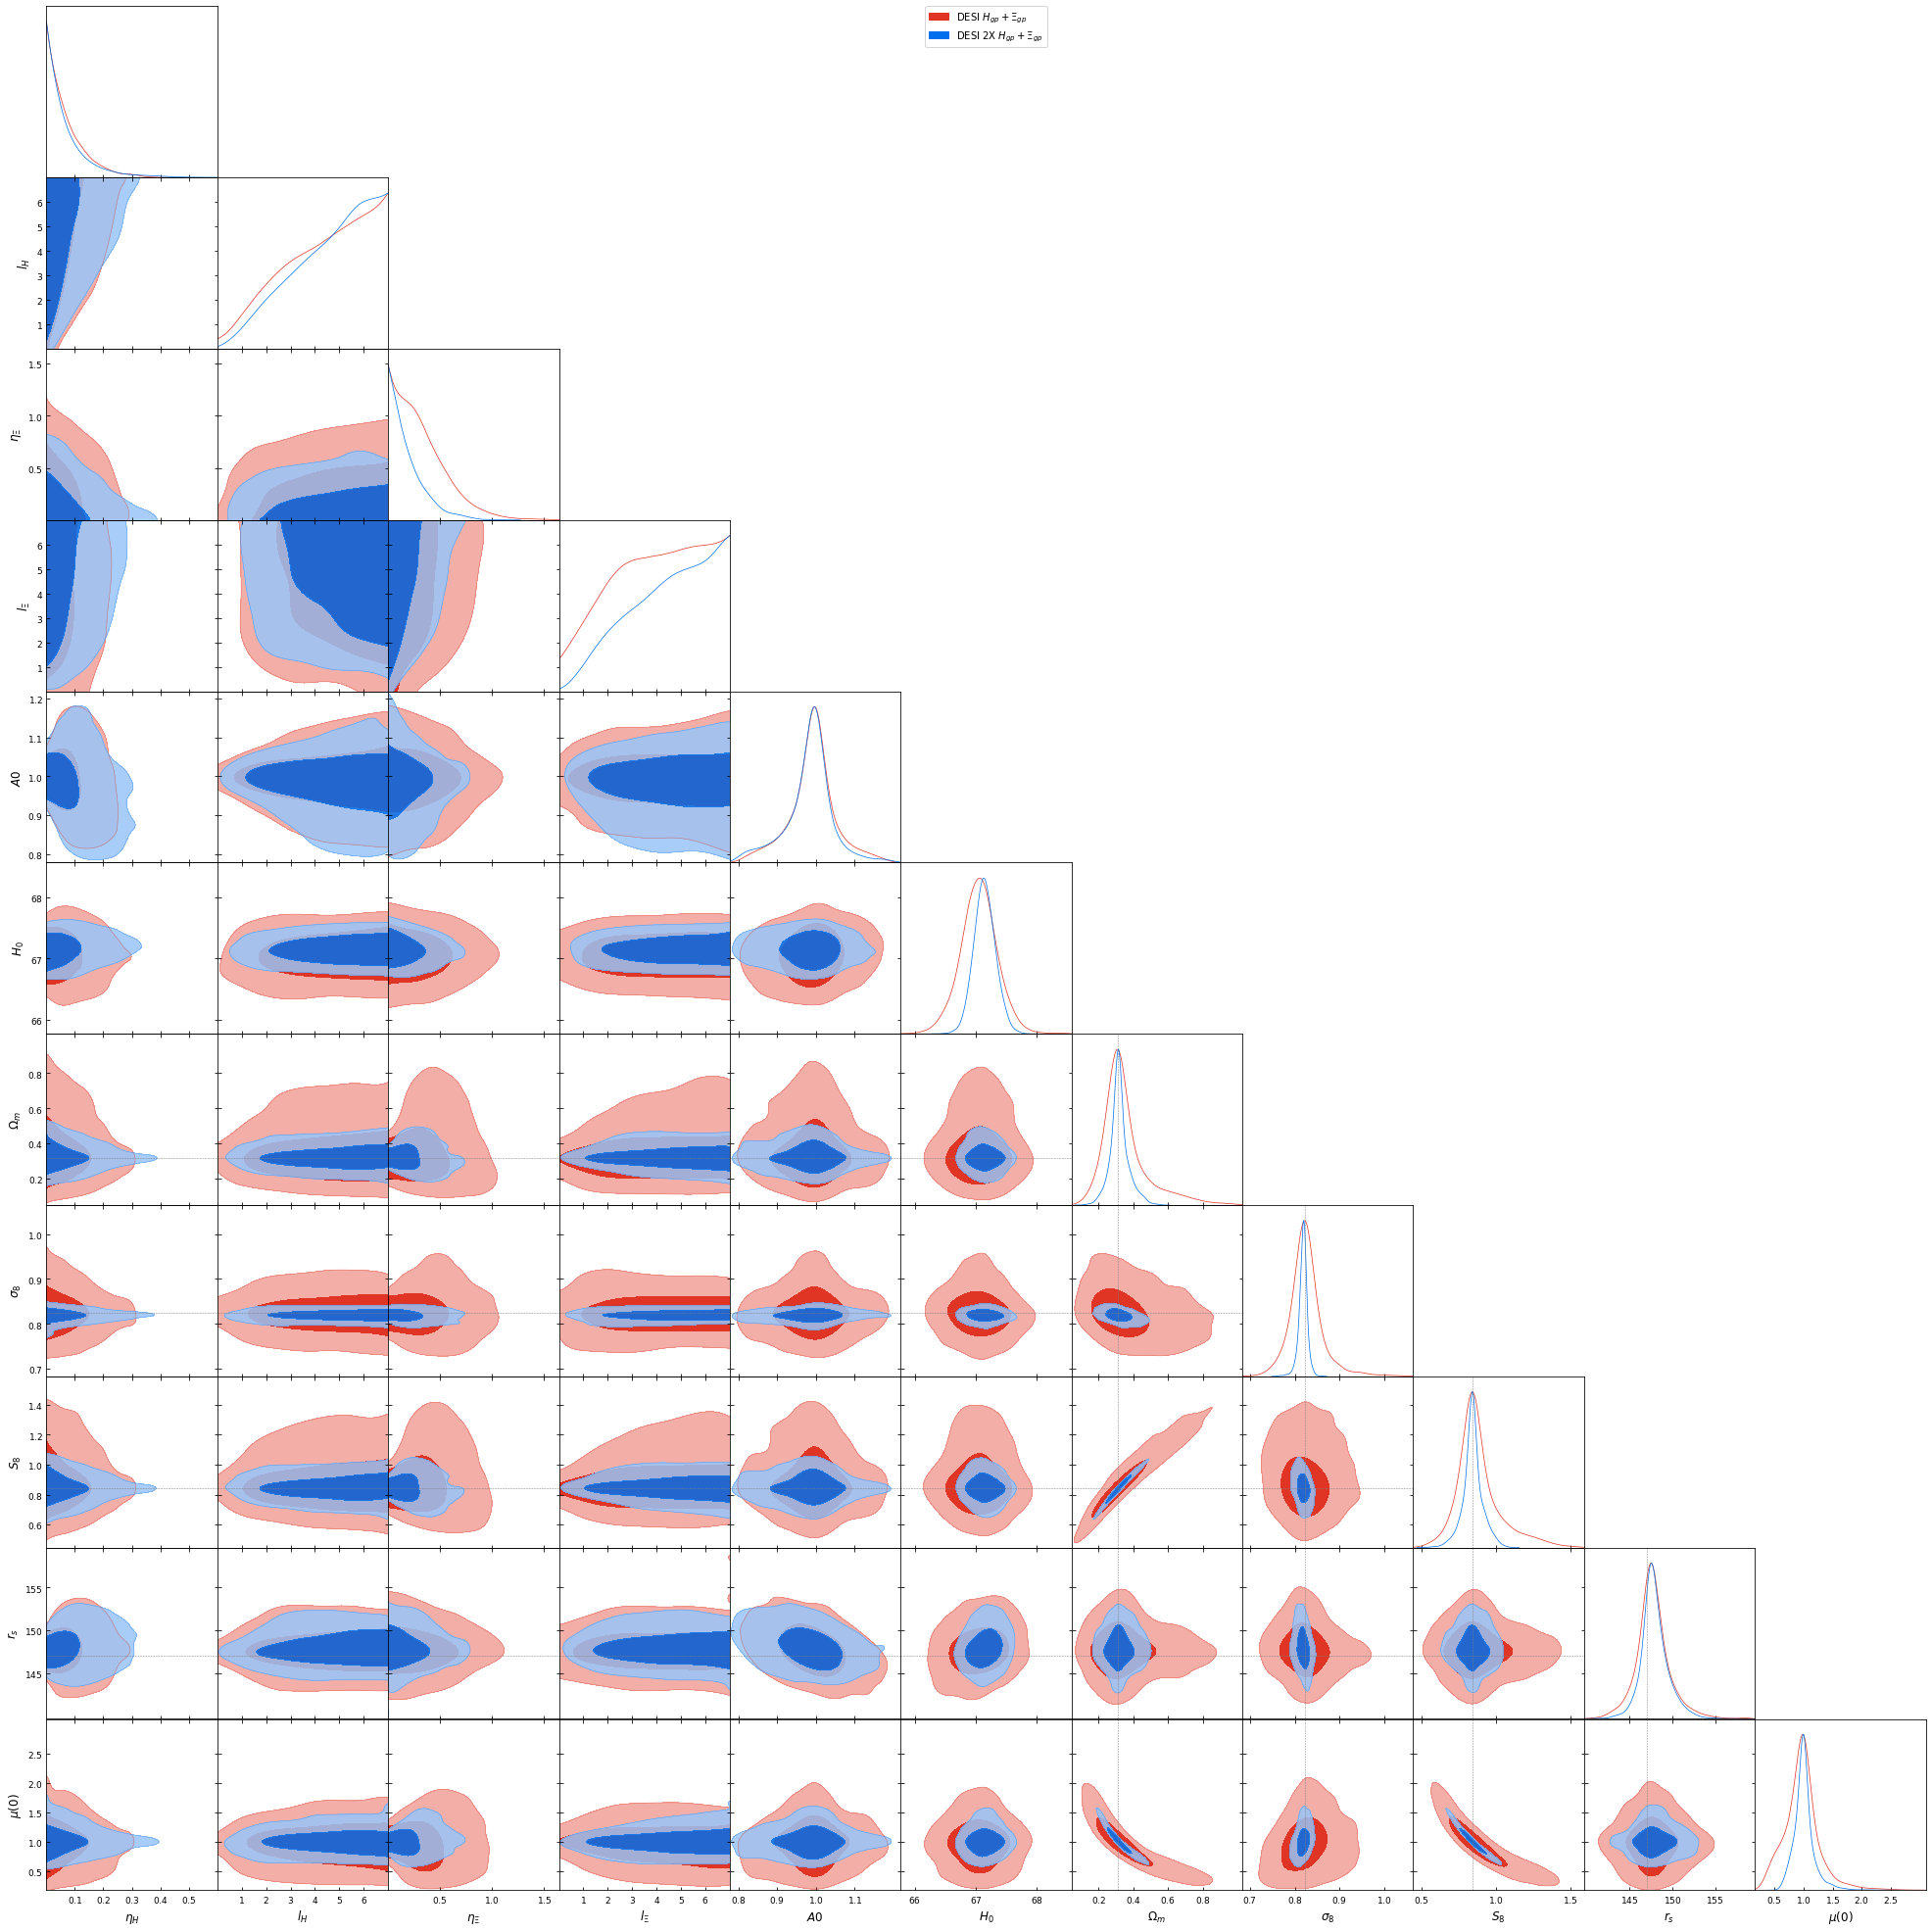

In [29]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([DESI_HXi_samples, DESI_2X_HXi_samples],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                         'rd':147.06546072,
                         'M': -19.2})
              
g.export('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/triangle_Xi_H.pdf')

# Xi

In [30]:
dXi_Xi_m, dXi_Xi_s = get_m_s(1+Xi['DXiz'])
dXi_Xi_LCDM_m, dXi_Xi_LCDM_s = get_m_s(1+Xi_LCDM['DXiz'])
dXi_Xi_wCDM_m, dXi_Xi_wCDM_s = get_m_s(1+Xi_wCDM['DXiz'])
dXi_Xi_bfWms8_m, dXi_Xi_bfWms8_s = get_m_s(1+Xi_bfWms8['DXiz'])
dXi_HXi_noA0_m, dXi_HXi_noA0_s = get_m_s(1+HXi_noA0['DXiz'])
dXi_HXi_m, dXi_HXi_s = get_m_s(1+HXi['DXiz'])

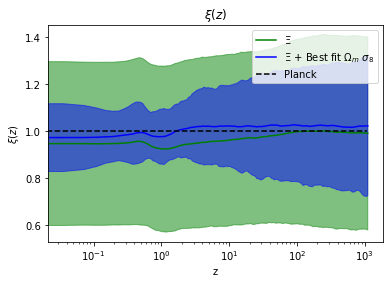

In [31]:
plt.plot(z_arr,  dXi_Xi_m, color ='g', label='$\Xi$')
plt.fill_between(z_arr, dXi_Xi_m+dXi_Xi_s,
                 dXi_Xi_m-dXi_Xi_s, color='g', alpha=.5)

#plt.plot(z_arr,  dXi_Xi_LCDM_m, color ='m', label='$\Xi^{\Lambda CDM}$')
#plt.fill_between(z_arr, dXi_Xi_LCDM_m+dXi_Xi_LCDM_s,
#                 dXi_Xi_LCDM_m-dXi_Xi_LCDM_s, color='m', alpha=.5)

#plt.plot(z_arr,  dXi_Xi_wCDM_m, color ='y', label='$\Xi^{wCDM}$')
#plt.fill_between(z_arr, dXi_Xi_wCDM_m+dXi_Xi_wCDM_s,
#                 dXi_Xi_wCDM_m-dXi_Xi_wCDM_s, color='y', alpha=.5)


plt.plot(z_arr,  dXi_Xi_bfWms8_m, color ='b', label='$\Xi$ + Best fit $\Omega_m$ $\sigma_8$')
plt.fill_between(z_arr, dXi_Xi_bfWms8_m+dXi_Xi_bfWms8_s,
                 dXi_Xi_bfWms8_m-dXi_Xi_bfWms8_s, color='b', alpha=.5)

plt.plot(z_planck, np.ones_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlabel("z")
plt.ylabel(r"$ \xi(z)$")
plt.title(r"$\xi(z)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/Xibf_comp.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/Xibf_comp.pdf')  

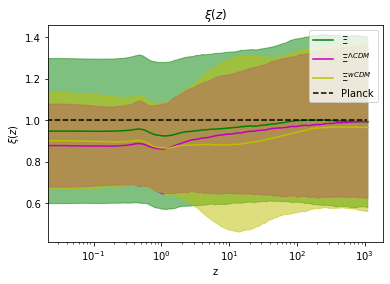

In [32]:
plt.plot(z_arr,  dXi_Xi_m, color ='g', label='$\Xi$')
plt.fill_between(z_arr, dXi_Xi_m+dXi_Xi_s,
                 dXi_Xi_m-dXi_Xi_s, color='g', alpha=.5)

plt.plot(z_arr,  dXi_Xi_LCDM_m, color ='m', label='$\Xi^{\Lambda CDM}$')
plt.fill_between(z_arr, dXi_Xi_LCDM_m+dXi_Xi_LCDM_s,
                 dXi_Xi_LCDM_m-dXi_Xi_LCDM_s, color='m', alpha=.5)

plt.plot(z_arr,  dXi_Xi_wCDM_m, color ='y', label='$\Xi^{wCDM}$')
plt.fill_between(z_arr, dXi_Xi_wCDM_m+dXi_Xi_wCDM_s,
                 dXi_Xi_wCDM_m-dXi_Xi_wCDM_s, color='y', alpha=.5)

#plt.plot(z_arr,  dXi_Xi_bfWms8_m, color ='b', label='$\Xi$ + Best fit $\Omega_m$ $\sigma_8$')
#plt.fill_between(z_arr, dXi_Xi_bfWms8_m+dXi_Xi_bfWms8_s,
#                 dXi_Xi_bfWms8_m-dXi_Xi_bfWms8_s, color='b', alpha=.5)

plt.plot(z_planck, np.ones_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlabel("z")
plt.ylabel(r"$ \xi(z)$")
plt.title(r"$\xi(z)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/Xibf_comp.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/Xibf_comp.pdf')  

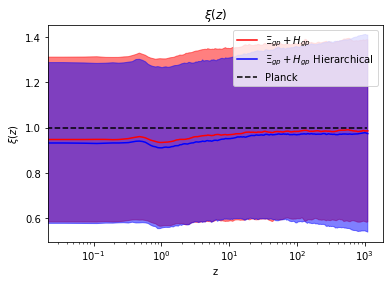

In [33]:
plt.plot(z_arr,  dXi_HXi_m, color ='r', label='$\Xi_{gp}+H_{gp}$')
plt.fill_between(z_arr, dXi_HXi_m+dXi_HXi_s,
                 dXi_HXi_m-dXi_HXi_s, color='r', alpha=.5)

plt.plot(z_arr,  dXi_HXi_noA0_m, color ='b', label='$\Xi_{gp}+H_{gp}$ Hierarchical')
plt.fill_between(z_arr, dXi_HXi_noA0_m+dXi_HXi_noA0_s,
                 dXi_HXi_noA0_m-dXi_HXi_noA0_s, color='b', alpha=.5)

#plt.plot(z_arr,  dXi_Xi_m, color ='g', label='$\Xi$')
#.fill_between(z_arr, dXi_Xi_m+dXi_Xi_s,
#                 dXi_Xi_m-dXi_Xi_s, color='g', alpha=.5)


plt.plot(z_planck, np.ones_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlabel("z")
plt.ylabel(r"$ \xi(z)$")
plt.title(r"$\xi(z)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/Xi_comp.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/Xi_comp.pdf')  

# d_H gp 

In [34]:
dH_H_m, dH_H_s = get_m_s(H['DHz'])
dH_HXi_noA0_m, dH_HXi_noA0_s = get_m_s(HXi_noA0['DHz'])
dH_HXi_m, dH_HXi_s = get_m_s(HXi['DHz'])
Planck = data_class.Planck
z_planck = data_class.z_planck

<ipython-input-35-668ef0911fed>:13: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)


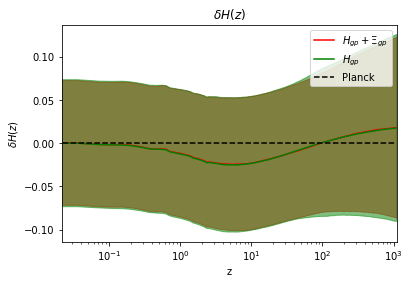

In [35]:
plt.plot(z_arr,  dH_HXi_m, color ='r', label='$H_{gp}+\Xi_{gp}$')
plt.fill_between(z_arr, dH_HXi_m+dH_HXi_s,
                 dH_HXi_m-dH_HXi_s, color='r', alpha=.5)

plt.plot(z_arr,  dH_H_m, color ='g', label='$H_{gp}$')
plt.fill_between(z_arr, dH_H_m+dH_H_s,
                 dH_H_m-dH_H_s, color='g', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')


plt.xscale('log')
plt.xlim(0, 1100)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/dH_Xi_H.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/dH_Xi_H.pdf')  

<ipython-input-36-ca505b5e1d9d>:13: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)


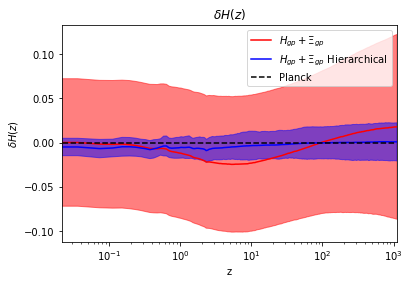

In [36]:
plt.plot(z_arr,  dH_HXi_m, color ='r', label='$H_{gp}+\Xi_{gp}$')
plt.fill_between(z_arr, dH_HXi_m+dH_HXi_s,
                 dH_HXi_m-dH_HXi_s, color='r', alpha=.5)
plt.plot(z_arr,  dH_HXi_noA0_m, color ='b', label='$H_{gp}+\Xi_{gp}$ Hierarchical')
plt.fill_between(z_arr, dH_HXi_noA0_m+dH_HXi_noA0_s,
                 dH_HXi_noA0_m-dH_HXi_noA0_s, color='b', alpha=.5)


plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')


plt.xscale('log')
plt.xlim(0, 1100)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/dH_Xi_H.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/dH_Xi_H.pdf')  

# Plots

In [37]:
H_H_m, H_H_s = get_m_s(H['Hz'])
H_Xi_m, H_Xi_s = get_m_s(Xi['Hz'])
H_Xi_LCDM_m, H_Xi_LCDM_s = get_m_s(Xi_LCDM['Hz'])
H_Xi_wCDM_m, H_Xi_wCDM_s = get_m_s(Xi_wCDM['Hz'])
H_HXi_noA0_m, H_HXi_noA0_s = get_m_s(HXi_noA0['Hz'])
H_HXi_m, H_HXi_s = get_m_s(HXi['Hz'])

In [38]:
dM_H_m, dM_H_s = get_m_s(H['dMz'])
dM_Xi_m, dM_Xi_s = get_m_s(H['dMz'])
dM_Xi_LCDM_m, dM_Xi_LCDM_s = get_m_s(Xi_LCDM['dMz'])
dM_Xi_wCDM_m, dM_Xi_wCDM_s = get_m_s(Xi_wCDM['dMz'])
dM_HXi_noA0_m, dM_HXi_noA0_s = get_m_s(HXi_noA0['dMz'])
dM_HXi_m, dM_HXi_s = get_m_s(HXi['dMz'])

In [39]:
fs8_H_m, fs8_H_s = get_m_s(H['fs8z'])
fs8_HXi_m, fs8_HXi_s = get_m_s(HXi['fs8z'])
fs8_HXi_noA0_m, fs8_HXi_noA0_s = get_m_s(HXi_noA0['fs8z'])
fs8_Xi_m, fs8_Xi_s = get_m_s(Xi['fs8z'])
fs8_Xi_LCDM_m, fs8_Xi_LCDM_s = get_m_s(Xi_LCDM['fs8z'])
fs8_Xi_wCDM_m, fs8_Xi_wCDM_s = get_m_s(Xi_wCDM['fs8z'])
fs8_Xi_bfWms8_m, fs8_Xi_bfWms8_s = get_m_s(Xi_bfWms8['fs8z'])

fs8_Xi_LCDM_gro_m, fs8_Xi_LCDM_gro_s = get_m_s(Xi_LCDM_gro['fs8z'])
fs8_Xi_wCDM_gro_m, fs8_Xi_wCDM_gro_s = get_m_s(Xi_wCDM_gro['fs8z'])
fs8_HXi_gro_m, fs8_HXi_gro_s = get_m_s(HXi_gro['fs8z'])

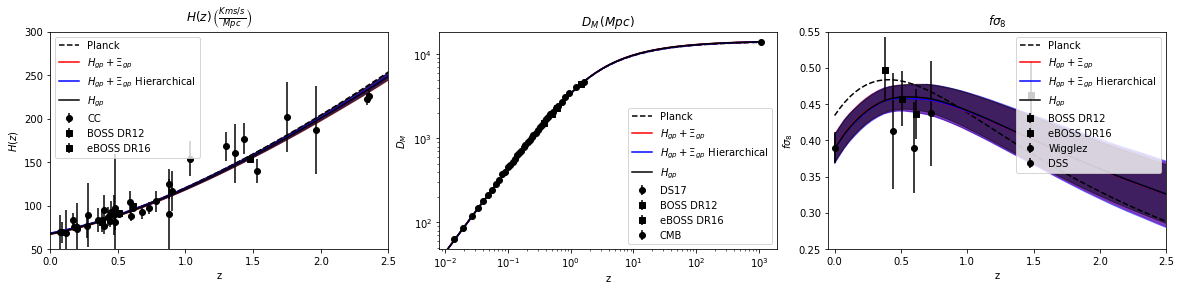

In [40]:
fig=plt.figure(figsize=(20,4))
fig.subplots_adjust(wspace=0.15)

ax1 = plt.subplot(131)
plt.plot(z_planck, Planck['Hkms_arr'], 'k--', label='Planck')
plt.errorbar(CC_data['z'], CC_data['data'], yerr = CC_data['err'], fmt='ko', label='CC')
plt.errorbar(BOSS_data['z'], BOSS_data['para_data'], yerr=BOSS_data['para_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], c/1000/(eBOSS_data['para_data']*eBOSS_data['rd']), 
             yerr = 1/eBOSS_data['rd']/(np.array([0.47])), fmt='ks', label='eBOSS DR16')

plt.plot(z_arr,  H_HXi_m, color ='r', label='$H_{gp}+\Xi_{gp}$')
plt.fill_between(z_arr, H_HXi_m+H_HXi_s,
                 H_HXi_m-H_HXi_s, color='r', alpha=.5)
plt.plot(z_arr,  H_HXi_noA0_m, color ='b', label='$H_{gp}+\Xi_{gp}$ Hierarchical')
plt.fill_between(z_arr, H_HXi_noA0_m+H_HXi_noA0_s,
                 H_HXi_noA0_m-H_HXi_noA0_s, color='b', alpha=.5)
plt.plot(z_arr,  H_H_m, color ='k', label='$H_{gp}$')
plt.fill_between(z_arr, H_H_m+H_H_s,
                 H_H_m-H_H_s, color='k', alpha=.5)

plt.xlim(0, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();
ax2 = plt.subplot(132)

plt.plot(z_planck, Planck['dM_arr'], 'k--', label='Planck')

plt.errorbar(DS17_data['z'], (10**((DS17_data['data']-25+19.49)/5))/(1+DS17_data['z']),
             yerr=(10**(DS17_data['err']/5))/(1+DS17_data['z']), fmt='ko', label='DS17')
plt.errorbar(BOSS_data['z'], BOSS_data['perp_data'], yerr=BOSS_data['perp_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['perp_data']*eBOSS_data['rd'],
             yerr=np.array([0.79])*eBOSS_data['rd'], fmt='ks', label='eBOSS DR16')
plt.errorbar(CMB_data['z'], (1/CMB_data['data'])*(100*CMB_data['rd']),
             yerr=(1/CMB_data['err'])*1/(100*CMB_data['rd']), fmt='ko', label='CMB')

plt.plot(z_arr,  dM_HXi_m, color ='r', label='$H_{gp}+\Xi_{gp}$')
plt.fill_between(z_arr, dM_HXi_m+dM_HXi_s,
                 dM_HXi_m-dM_HXi_s, color='r', alpha=.5)
plt.plot(z_arr,  dM_HXi_noA0_m, color ='b', label='$H_{gp}+\Xi_{gp}$ Hierarchical')
plt.fill_between(z_arr, dM_HXi_noA0_m+dM_HXi_noA0_s,
                 dM_HXi_noA0_m-dM_HXi_noA0_s, color='b', alpha=.5)
plt.plot(z_arr,  dM_H_m, color ='k', label='$H_{gp}$')
plt.fill_between(z_arr, dM_H_m+dM_H_s, dM_H_m-dM_H_s, color='k', alpha=.5)
plt.xlabel("z")
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();

ax3 = plt.subplot(133)
plt.plot(z_planck, Planck['fs8_arr'], 'k--', label='Planck')
plt.errorbar(BOSS_data['z'], BOSS_data['fs8_data'], yerr=BOSS_data['fs8_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['fs8_data'], yerr=eBOSS_data['fs8_err'], fmt='ks', label='eBOSS DR16')
plt.errorbar(Wigglez_data['z'], Wigglez_data['data'], yerr=Wigglez_data['err'], fmt='ko', label='Wigglez')
plt.errorbar(DSS_data['z'], DSS_data['data'], yerr=DSS_data['err'], fmt='ko', label='DSS')

plt.plot(z_arr,  fs8_HXi_m, color ='r', label='$H_{gp}+\Xi_{gp}$')
plt.fill_between(z_arr, fs8_HXi_m+fs8_HXi_s,
                 fs8_HXi_m-fs8_HXi_s, color='r', alpha=.5)
plt.plot(z_arr,  fs8_HXi_noA0_m, color ='b', label='$H_{gp}+\Xi_{gp}$ Hierarchical')
plt.fill_between(z_arr, fs8_HXi_noA0_m+fs8_HXi_noA0_s,
                 fs8_HXi_noA0_m-fs8_HXi_noA0_s, color='b', alpha=.5)
plt.plot(z_arr,  fs8_H_m, color ='k', label='$H_{gp}$')
plt.fill_between(z_arr, fs8_H_m+fs8_H_s,
                 fs8_H_m-fs8_H_s, color='k', alpha=.5)

plt.xlim(-0.05, 2.5)
plt.ylim(0.25, 0.55)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();



#os.remove('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/tests_cosmo_functions.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/tests_cosmo_functions.pdf')  

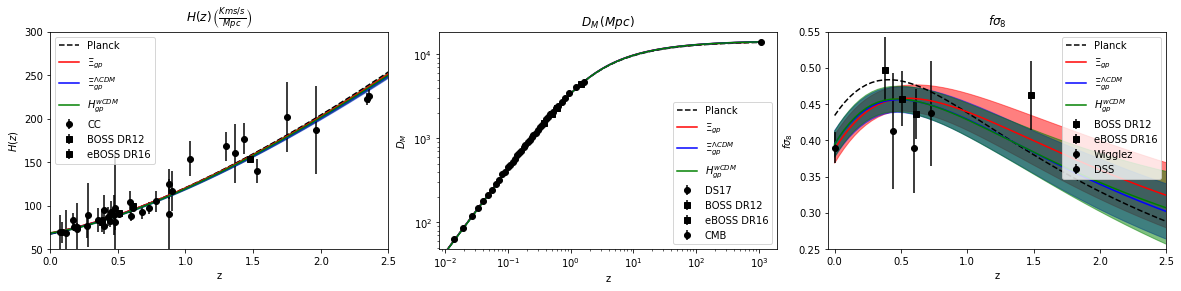

In [41]:
fig=plt.figure(figsize=(20,4))
fig.subplots_adjust(wspace=0.15)

ax1 = plt.subplot(131)
plt.plot(z_planck, Planck['Hkms_arr'], 'k--', label='Planck')
plt.errorbar(CC_data['z'], CC_data['data'], yerr = CC_data['err'], fmt='ko', label='CC')
plt.errorbar(BOSS_data['z'], BOSS_data['para_data'], yerr=BOSS_data['para_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], c/1000/(eBOSS_data['para_data']*eBOSS_data['rd']), 
             yerr = 1/eBOSS_data['rd']/(np.array([0.47])), fmt='ks', label='eBOSS DR16')

plt.plot(z_arr,  H_Xi_m, color ='r', label='$\Xi_{gp}$')
plt.fill_between(z_arr, H_Xi_m+H_Xi_s,
                 H_Xi_m-H_Xi_s, color='r', alpha=.5)
plt.plot(z_arr,  H_Xi_LCDM_m, color ='b', label='$\Xi_{gp}^{\Lambda CDM}$')
plt.fill_between(z_arr, H_Xi_LCDM_m+H_Xi_LCDM_s,
                 H_Xi_LCDM_m-H_Xi_LCDM_s, color='b', alpha=.5)
plt.plot(z_arr,  H_Xi_wCDM_m, color ='g', label='$H_{gp}^{wCDM}$')
plt.fill_between(z_arr, H_Xi_wCDM_m+H_Xi_wCDM_s,
                 H_Xi_wCDM_m-H_Xi_wCDM_s, color='g', alpha=.5)

plt.xlim(0, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();
ax2 = plt.subplot(132)

plt.plot(z_planck, Planck['dM_arr'], 'k--', label='Planck')

plt.errorbar(DS17_data['z'], (10**((DS17_data['data']-25+19.49)/5))/(1+DS17_data['z']),
             yerr=(10**(DS17_data['err']/5))/(1+DS17_data['z']), fmt='ko', label='DS17')
plt.errorbar(BOSS_data['z'], BOSS_data['perp_data'], yerr=BOSS_data['perp_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['perp_data']*eBOSS_data['rd'],
             yerr=np.array([0.79])*eBOSS_data['rd'], fmt='ks', label='eBOSS DR16')
plt.errorbar(CMB_data['z'], (1/CMB_data['data'])*(100*CMB_data['rd']),
             yerr=(1/CMB_data['err'])*1/(100*CMB_data['rd']), fmt='ko', label='CMB')

plt.plot(z_arr,  dM_Xi_m, color ='r', label='$\Xi_{gp}$')
plt.fill_between(z_arr, dM_Xi_m+dM_Xi_s,
                 dM_Xi_m-dM_Xi_s, color='r', alpha=.5)
plt.plot(z_arr,  dM_Xi_LCDM_m, color ='b', label='$\Xi_{gp}^{\Lambda CDM}$')
plt.fill_between(z_arr, dM_Xi_LCDM_m+dM_Xi_LCDM_s,
                 dM_Xi_LCDM_m-dM_Xi_LCDM_s, color='b', alpha=.5)
plt.plot(z_arr,  dM_Xi_wCDM_m, color ='g', label='$H_{gp}^{wCDM}$')
plt.fill_between(z_arr, dM_Xi_wCDM_m+dM_Xi_wCDM_s,
                 dM_Xi_wCDM_m-dM_Xi_wCDM_s, color='g', alpha=.5)
plt.xlabel("z")
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();

ax3 = plt.subplot(133)
plt.plot(z_planck, Planck['fs8_arr'], 'k--', label='Planck')
plt.errorbar(BOSS_data['z'], BOSS_data['fs8_data'], yerr=BOSS_data['fs8_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['fs8_data'], yerr=eBOSS_data['fs8_err'], fmt='ks', label='eBOSS DR16')
plt.errorbar(Wigglez_data['z'], Wigglez_data['data'], yerr=Wigglez_data['err'], fmt='ko', label='Wigglez')
plt.errorbar(DSS_data['z'], DSS_data['data'], yerr=DSS_data['err'], fmt='ko', label='DSS')

plt.plot(z_arr,  fs8_Xi_m, color ='r', label='$\Xi_{gp}$')
plt.fill_between(z_arr, fs8_Xi_m+fs8_Xi_s,
                 fs8_Xi_m-fs8_Xi_s, color='r', alpha=.5)
plt.plot(z_arr,  fs8_Xi_LCDM_m, color ='b', label='$\Xi_{gp}^{\Lambda CDM}$')
plt.fill_between(z_arr, fs8_Xi_LCDM_m+fs8_Xi_LCDM_s,
                 fs8_Xi_LCDM_m-fs8_Xi_LCDM_s, color='b', alpha=.5)
plt.plot(z_arr,  fs8_Xi_wCDM_m, color ='g', label='$H_{gp}^{wCDM}$')
plt.fill_between(z_arr, fs8_Xi_wCDM_m+fs8_Xi_wCDM_s,
                 fs8_Xi_wCDM_m-fs8_Xi_wCDM_s, color='g', alpha=.5)

plt.xlim(-0.05, 2.5)
plt.ylim(0.25, 0.55)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();



#os.remove('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/tests_cosmo_functions.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/tests_cosmo_functions.pdf')  

# H(Z)

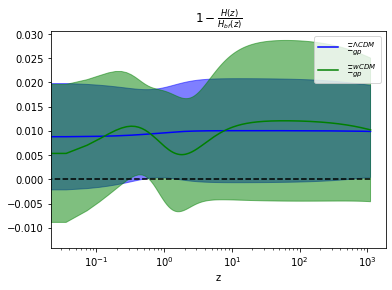

In [42]:
#plt.plot(z_planck, Planck['Hkms_arr'], 'k--', label='Planck')
#plt.errorbar(CC_data['z'], CC_data['data'], yerr = CC_data['err'], fmt='ko', label='CC')
#plt.errorbar(BOSS_data['z'], BOSS_data['para_data'], yerr=BOSS_data['para_err'], fmt='ks', label='BOSS DR12')
#plt.errorbar(eBOSS_data['z'], c/1000/(eBOSS_data['para_data']*eBOSS_data['rd']), 
#             yerr = 1/eBOSS_data['rd']/(np.array([0.47])), fmt='ks', label='eBOSS DR16')

plt.plot(z_arr, np.zeros_like(z_arr), 'k--')
plt.plot(z_arr,  1-H_Xi_LCDM_m/H_Xi_m, color ='b', label='$\Xi_{gp}^{\Lambda CDM}$')
plt.fill_between(z_arr, 1-(H_Xi_LCDM_m+H_Xi_LCDM_s)/H_Xi_m,
                 1-(H_Xi_LCDM_m-H_Xi_LCDM_s)/H_Xi_m, color='b', alpha=.5)
plt.plot(z_arr,  1-H_Xi_wCDM_m/H_Xi_m, color ='g', label='$\Xi_{gp}^{wCDM}$')
plt.fill_between(z_arr, 1-(H_Xi_wCDM_m+H_Xi_wCDM_s)/H_Xi_m,
                 1-(H_Xi_wCDM_m-H_Xi_wCDM_s)/H_Xi_m, color='g', alpha=.5)

plt.xscale('log')
plt.xlabel("z")
plt.title(r"$1 -\frac{H(z)}{H_{bf}(z)}$")
plt.legend();

# fs8

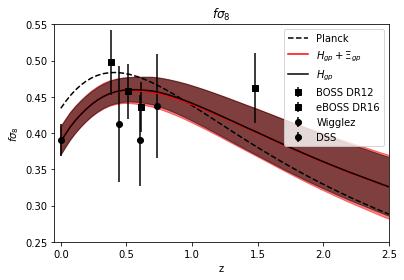

In [43]:
plt.plot(z_planck, Planck['fs8_arr'], 'k--', label='Planck')
plt.errorbar(BOSS_data['z'], BOSS_data['fs8_data'], yerr=BOSS_data['fs8_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['fs8_data'], yerr=eBOSS_data['fs8_err'], fmt='ks', label='eBOSS DR16')
plt.errorbar(Wigglez_data['z'], Wigglez_data['data'], yerr=Wigglez_data['err'], fmt='ko', label='Wigglez')
plt.errorbar(DSS_data['z'], DSS_data['data'], yerr=DSS_data['err'], fmt='ko', label='DSS')

plt.plot(z_arr,  fs8_HXi_m, color ='r', label='$H_{gp}+\Xi_{gp}$')
plt.fill_between(z_arr, fs8_HXi_m+fs8_HXi_s,
                 fs8_HXi_m-fs8_HXi_s, color='r', alpha=.5)
plt.plot(z_arr,  fs8_H_m, color ='k', label='$H_{gp}$')
plt.fill_between(z_arr, fs8_H_m+fs8_H_s,
                 fs8_H_m-fs8_H_s, color='k', alpha=.5)




plt.xlim(-0.05, 2.5)
plt.ylim(0.25, 0.55)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/fs8_comp.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/fs8_comp.pdf')

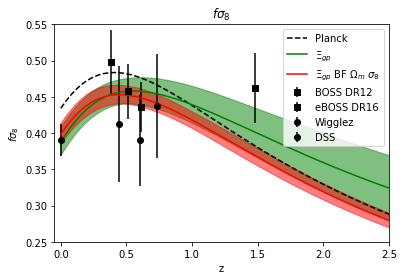

In [44]:
plt.plot(z_planck, Planck['fs8_arr'], 'k--', label='Planck')
plt.errorbar(BOSS_data['z'], BOSS_data['fs8_data'], yerr=BOSS_data['fs8_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['fs8_data'], yerr=eBOSS_data['fs8_err'], fmt='ks', label='eBOSS DR16')
plt.errorbar(Wigglez_data['z'], Wigglez_data['data'], yerr=Wigglez_data['err'], fmt='ko', label='Wigglez')
plt.errorbar(DSS_data['z'], DSS_data['data'], yerr=DSS_data['err'], fmt='ko', label='DSS')

plt.plot(z_arr,  fs8_Xi_m, color ='g', label='$\Xi_{gp}$')
plt.fill_between(z_arr, fs8_Xi_m+fs8_Xi_s, fs8_Xi_m-fs8_Xi_s, color='g', alpha=.5)

plt.plot(z_arr,  fs8_Xi_bfWms8_m, color ='r', label='$\Xi_{gp}$ BF $\Omega_m$ $\sigma_8$')
plt.fill_between(z_arr, fs8_Xi_bfWms8_m+fs8_Xi_bfWms8_s, fs8_Xi_bfWms8_m-fs8_Xi_bfWms8_s, color='r', alpha=.5)




plt.xlim(-0.05, 2.5)
plt.ylim(0.25, 0.55)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/fs8_comp.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/fs8_comp.pdf')

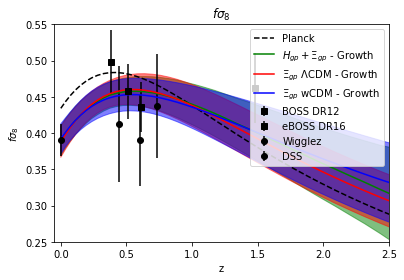

In [45]:
plt.plot(z_planck, Planck['fs8_arr'], 'k--', label='Planck')
plt.errorbar(BOSS_data['z'], BOSS_data['fs8_data'], yerr=BOSS_data['fs8_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['fs8_data'], yerr=eBOSS_data['fs8_err'], fmt='ks', label='eBOSS DR16')
plt.errorbar(Wigglez_data['z'], Wigglez_data['data'], yerr=Wigglez_data['err'], fmt='ko', label='Wigglez')
plt.errorbar(DSS_data['z'], DSS_data['data'], yerr=DSS_data['err'], fmt='ko', label='DSS')

plt.plot(z_arr,  fs8_HXi_gro_m, color ='g', label='$H_{gp}+\Xi_{gp}$ - Growth')
plt.fill_between(z_arr, fs8_HXi_gro_m+fs8_HXi_gro_s,
                 fs8_HXi_gro_m-fs8_HXi_gro_s, color='g', alpha=.5)

plt.plot(z_arr,  fs8_Xi_LCDM_gro_m, color ='r', label='$\Xi_{gp}$ $\Lambda$CDM - Growth')
plt.fill_between(z_arr, fs8_Xi_LCDM_gro_m+fs8_Xi_LCDM_gro_s,
                 fs8_Xi_LCDM_gro_m-fs8_Xi_LCDM_gro_s, color='r', alpha=.5)

plt.plot(z_arr,  fs8_Xi_wCDM_gro_m, color ='b', label='$\Xi_{gp}$ wCDM - Growth')
plt.fill_between(z_arr, fs8_Xi_wCDM_gro_m+fs8_Xi_wCDM_gro_s,
                 fs8_Xi_wCDM_gro_m-fs8_Xi_wCDM_gro_s, color='b', alpha=.5)


plt.xlim(-0.05, 2.5)
plt.ylim(0.25, 0.55)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/fs8_comp.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/fs8_comp.pdf')

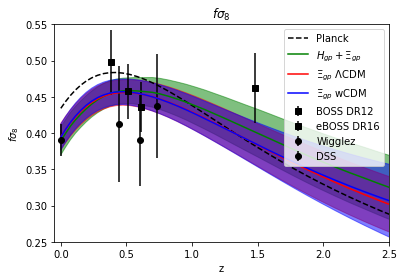

In [46]:
plt.plot(z_planck, Planck['fs8_arr'], 'k--', label='Planck')
plt.errorbar(BOSS_data['z'], BOSS_data['fs8_data'], yerr=BOSS_data['fs8_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['fs8_data'], yerr=eBOSS_data['fs8_err'], fmt='ks', label='eBOSS DR16')
plt.errorbar(Wigglez_data['z'], Wigglez_data['data'], yerr=Wigglez_data['err'], fmt='ko', label='Wigglez')
plt.errorbar(DSS_data['z'], DSS_data['data'], yerr=DSS_data['err'], fmt='ko', label='DSS')

plt.plot(z_arr,  fs8_HXi_m, color ='g', label='$H_{gp}+\Xi_{gp}$')
plt.fill_between(z_arr, fs8_HXi_m+fs8_HXi_s,
                 fs8_HXi_m-fs8_HXi_s, color='g', alpha=.5)

plt.plot(z_arr,  fs8_Xi_LCDM_m, color ='r', label='$\Xi_{gp}$ $\Lambda$CDM')
plt.fill_between(z_arr, fs8_Xi_LCDM_m+fs8_Xi_LCDM_s,
                 fs8_Xi_LCDM_m-fs8_Xi_LCDM_s, color='r', alpha=.5)

plt.plot(z_arr,  fs8_Xi_wCDM_m, color ='b', label='$\Xi_{gp}$ wCDM')
plt.fill_between(z_arr, fs8_Xi_wCDM_m+fs8_Xi_wCDM_s,
                 fs8_Xi_wCDM_m-fs8_Xi_wCDM_s, color='b', alpha=.5)


plt.xlim(-0.05, 2.5)
plt.ylim(0.25, 0.55)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/fs8_comp.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/fs8_comp.pdf')